In [5]:
from iohblade.loggers import ExperimentLogger
from iohblade import plot_convergence, plot_experiment_CEG, plot_boxplot_fitness_hue, plot_boxplot_fitness, fitness_table
import os

logger = ExperimentLogger('/data/neocortex/BBOB', True)

data = logger.get_data()

"""
    mutation_prompts1 = [
        "Refine and simplify the selected algorithm to improve it.",  # simplify mutation
    ]
    mutation_prompts2 = [
        "Generate a new algorithm that is different from the algorithms you have tried before.", #new random solution
    ]
    mutation_prompts3 = [
        "Refine and simplify the selected solution to improve it.",  # simplify mutation
        "Generate a new algorithm that is different from the algorithms you have tried before.", #new random solution
    ]
    LLaMEA_method1 = LLaMEA(llm, budget=budget, name=f"LLaMEA-1", mutation_prompts=mutation_prompts1, n_parents=4, n_offspring=12, elitism=False) 
    LLaMEA_method2 = LLaMEA(llm, budget=budget, name=f"LLaMEA-2", mutation_prompts=mutation_prompts2, n_parents=4, n_offspring=12, elitism=False) 
    LLaMEA_method3 = LLaMEA(llm, budget=budget, name=f"LLaMEA-3", mutation_prompts=mutation_prompts3, n_parents=4, n_offspring=12, elitism=False) 
    LLaMEA_method4 = LLaMEA(llm, budget=budget, name=f"LLaMEA-4", mutation_prompts=mutation_prompts3, n_parents=1, n_offspring=1, elitism=True) 
    LLaMEA_method5 = LLaMEA(llm, budget=budget, name=f"LLaMEA-5", mutation_prompts=None, adaptive_mutation=True, n_parents=4, n_offspring=12, elitism=False) 
    LLaMEA_method6 = LLaMEA(llm, budget=budget, name=f"LLaMEA-6", mutation_prompts=None, adaptive_mutation=True, n_parents=1, n_offspring=1, elitism=True) 
"""
data

,method_name,problem_name,llm_name,method,problem,llm,solution,log_dir,seed
0,LLaMEA-1,BBOB,gpt-4.1-2025-04-14,"{'method_name': 'LLaMEA-1', 'budget': 100, 'kw...","{'name': 'BBOB', 'dims': [5], 'training_instan...","{'model': 'gpt-4.1-2025-04-14', 'code_pattern'...","{'id': 'c8898c97-62f8-457a-9294-20d8f8ab8514',...",/data/neocortex/BBOB/run-LLaMEA-1-BBOB-0,0
1,LLaMEA-1,BBOB,gpt-4.1-2025-04-14,"{'method_name': 'LLaMEA-1', 'budget': 100, 'kw...","{'name': 'BBOB', 'dims': [5], 'training_instan...","{'model': 'gpt-4.1-2025-04-14', 'code_pattern'...","{'id': 'f9e31a79-d60a-431e-923a-5605f59949c5',...",/data/neocortex/BBOB/run-LLaMEA-1-BBOB-1,1
2,LLaMEA-1,BBOB,gpt-4.1-2025-04-14,"{'method_name': 'LLaMEA-1', 'budget': 100, 'kw...","{'name': 'BBOB', 'dims': [5], 'training_instan...","{'model': 'gpt-4.1-2025-04-14', 'code_pattern'...","{'id': '2b06f541-6e41-4bf1-8c27-e4d157b27a7c',...",/data/neocortex/BBOB/run-LLaMEA-1-BBOB-2,2
3,LLaMEA-1,BBOB,gpt-4.1-2025-04-14,"{'method_name': 'LLaMEA-1', 'budget': 100, 'kw...","{'name': 'BBOB', 'dims': [5], 'training_instan...","{'model': 'gpt-4.1-2025-04-14', 'code_pattern'...","{'id': 'a2524756-88e7-47c5-93ac-3d8c932ce56a',...",/data/neocortex/BBOB/run-LLaMEA-1-BBOB-3,3
4,LLaMEA-1,BBOB,gpt-4.1-2025-04-14,"{'method_name': 'LLaMEA-1', 'budget': 100, 'kw...","{'name': 'BBOB', 'dims': [5], 'training_instan...","{'model': 'gpt-4.1-2025-04-14', 'code_pattern'...","{'id': '5dfd906a-64fe-4d3c-9151-3b4426cd647c',...",/data/neocortex/BBOB/run-LLaMEA-1-BBOB-4,4
5,LLaMEA-2,BBOB,gpt-4.1-2025-04-14,"{'method_name': 'LLaMEA-2', 'budget': 100, 'kw...","{'name': 'BBOB', 'dims': [5], 'training_instan...","{'model': 'gpt-4.1-2025-04-14', 'code_pattern'...","{'id': '592dfb7f-908b-42de-884c-f72f8a031221',...",/data/neocortex/BBOB/run-LLaMEA-2-BBOB-0,0
6,LLaMEA-2,BBOB,gpt-4.1-2025-04-14,"{'method_name': 'LLaMEA-2', 'budget': 100, 'kw...","{'name': 'BBOB', 'dims': [5], 'training_instan...","{'model': 'gpt-4.1-2025-04-14', 'code_pattern'...","{'id': '01be1b4c-f5c0-4cdb-bc24-e1dedb7b757e',...",/data/neocortex/BBOB/run-LLaMEA-2-BBOB-1,1
7,LLaMEA-2,BBOB,gpt-4.1-2025-04-14,"{'method_name': 'LLaMEA-2', 'budget': 100, 'kw...","{'name': 'BBOB', 'dims': [5], 'training_instan...","{'model': 'gpt-4.1-2025-04-14', 'code_pattern'...","{'id': '90f16320-0332-4c3a-81c5-f8a0d64bb1f2',...",/data/neocortex/BBOB/run-LLaMEA-2-BBOB-2,2
8,LLaMEA-2,BBOB,gpt-4.1-2025-04-14,"{'method_name': 'LLaMEA-2', 'budget': 100, 'kw...","{'name': 'BBOB', 'dims': [5], 'training_instan...","{'model': 'gpt-4.1-2025-04-14', 'code_pattern'...","{'id': 'edff29b4-510c-4003-a12d-2dfbb252f012',...",/data/neocortex/BBOB/run-LLaMEA-2-BBOB-3,3
9,LLaMEA-2,BBOB,gpt-4.1-2025-04-14,"{'method_name': 'LLaMEA-2', 'budget': 100, 'kw...","{'name': 'BBOB', 'dims': [5], 'training_instan...","{'model': 'gpt-4.1-2025-04-14', 'code_pattern'...","{'id': 'bbbe9d1d-bc59-4c27-96f3-9771267c70ff',...",/data/neocortex/BBOB/run-LLaMEA-2-BBOB-4,4


In [ ]:
import iohinspector
import polars as pl
from iohblade.behaviour_metrics import compute_behavior_metrics
from tqdm import tqdm
import pandas as pd

tqdm.pandas(desc="Processing runs")

def process_run(algid, seed, root="/data/neocortex/BBOB/ioh/"):
    manager = iohinspector.DataManager()
    path = f"{root}{algid}"
    if seed > 0:
        path = f"{root}{algid}-{seed}"
    if not os.path.exists(path):
        return {} # Skip if the path does not exist
    manager.add_folder(path)
    df = manager.load(monotonic=False, include_meta_data=True)
    return compute_behavior_metrics(df)

def wrapper(row):
    try:
        metrics = process_run(row['id'], row['seed'])
        return pd.Series(metrics)
    except Exception as e:
        # In case some runs are missing or broken
        print(f"Error processing id={row['id']}, seed={row['seed']}: {e}")
        return pd.Series({})

methods, problems = logger.get_methods_problems()
print(methods)
print(problems)

df = logger.get_problem_data(problem_name='BBOB')

# Apply to each row and concatenate the new columns
metrics_df = df.progress_apply(wrapper, axis=1)

# Join the new metrics with the original dataframe
df = pd.concat([df, metrics_df], axis=1)

print(df)

['LLaMEA-1', 'LLaMEA-2', 'LLaMEA-3', 'LLaMEA-4', 'LLaMEA-5', 'LLaMEA-6']
['BBOB']


Processing runs:   0%|          | 3/3000 [00:00<16:53,  2.96it/s]

Error processing id=bd8ea375-6189-4077-817d-9a9dda02cf90, seed=0: /data/neocortex/BBOB/ioh/bd8ea375-6189-4077-817d-9a9dda02cf90 not found


Processing runs:   2%|▏         | 66/3000 [00:25<19:56,  2.45it/s]

Error processing id=fa21ff01-474c-4049-ae2f-f0211854416e, seed=0: /data/neocortex/BBOB/ioh/fa21ff01-474c-4049-ae2f-f0211854416e not found


Processing runs:   4%|▎         | 106/3000 [00:39<10:37,  4.54it/s]

Error processing id=d0dd53a8-2646-46aa-a469-fde933b8075d, seed=1: /data/neocortex/BBOB/ioh/d0dd53a8-2646-46aa-a469-fde933b8075d not found


Processing runs:   4%|▎         | 107/3000 [00:40<13:56,  3.46it/s]

Error processing id=d6721e50-b44e-4e35-a43f-f5e5d71bd4d6, seed=1: /data/neocortex/BBOB/ioh/d6721e50-b44e-4e35-a43f-f5e5d71bd4d6 not found


Processing runs:   4%|▎         | 111/3000 [00:41<16:20,  2.95it/s]

Error processing id=f69470c1-3cfb-48ba-9f9b-0beae17db9aa, seed=1: /data/neocortex/BBOB/ioh/f69470c1-3cfb-48ba-9f9b-0beae17db9aa not found


Processing runs:   7%|▋         | 196/3000 [01:15<17:52,  2.62it/s]

Error processing id=25feda4d-5fbd-48da-8b40-186293122780, seed=1: /data/neocortex/BBOB/ioh/25feda4d-5fbd-48da-8b40-186293122780 not found


Processing runs:   7%|▋         | 204/3000 [01:18<15:15,  3.06it/s]

Error processing id=a56f007a-e507-4e40-bb5c-85d59a4bc891, seed=2: /data/neocortex/BBOB/ioh/a56f007a-e507-4e40-bb5c-85d59a4bc891 not found
Error processing id=9d3f0480-10be-4aef-ad63-7a9b145ad7df, seed=2: /data/neocortex/BBOB/ioh/9d3f0480-10be-4aef-ad63-7a9b145ad7df not found


Processing runs:   7%|▋         | 210/3000 [01:18<09:02,  5.14it/s]

Error processing id=207c8f1b-1440-4da7-87fe-af29e1cec001, seed=2: /data/neocortex/BBOB/ioh/207c8f1b-1440-4da7-87fe-af29e1cec001 not found


Processing runs:   7%|▋         | 213/3000 [01:20<14:32,  3.20it/s]

Error processing id=57fbb209-3c96-47da-bdaa-3ce5dd88ec9b, seed=2: /data/neocortex/BBOB/ioh/57fbb209-3c96-47da-bdaa-3ce5dd88ec9b not found


Processing runs:   7%|▋         | 221/3000 [01:23<18:02,  2.57it/s]

Error processing id=5e23188b-aa2f-4173-8137-2a07b38224d9, seed=2: /data/neocortex/BBOB/ioh/5e23188b-aa2f-4173-8137-2a07b38224d9 not found


Processing runs:   8%|▊         | 229/3000 [01:25<16:27,  2.81it/s]

Error processing id=76b39f4f-fa51-4616-b1dc-45e539d59c34, seed=2: /data/neocortex/BBOB/ioh/76b39f4f-fa51-4616-b1dc-45e539d59c34 not found


Processing runs:  10%|█         | 315/3000 [01:59<17:33,  2.55it/s]

Error processing id=ea1bae49-1d13-4a4d-9b51-100833245422, seed=3: /data/neocortex/BBOB/ioh/ea1bae49-1d13-4a4d-9b51-100833245422 not found


Processing runs:  11%|█         | 319/3000 [02:00<15:05,  2.96it/s]

Error processing id=417daeb7-4b65-4b51-872a-2aab17be6c3b, seed=3: /data/neocortex/BBOB/ioh/417daeb7-4b65-4b51-872a-2aab17be6c3b not found


Processing runs:  11%|█         | 322/3000 [02:01<14:00,  3.19it/s]

Error processing id=b19014b1-568e-4ab4-ba93-2c2b65ba4897, seed=3: /data/neocortex/BBOB/ioh/b19014b1-568e-4ab4-ba93-2c2b65ba4897 not found


Processing runs:  11%|█         | 328/3000 [02:03<15:20,  2.90it/s]

Error processing id=8f15c7c8-3fd1-4cff-8812-97cccc1663d7, seed=3: /data/neocortex/BBOB/ioh/8f15c7c8-3fd1-4cff-8812-97cccc1663d7 not found


Processing runs:  12%|█▏        | 369/3000 [02:19<17:19,  2.53it/s]

Error processing id=bb565217-22f9-4c60-91d9-e07d50d4afb3, seed=3: /data/neocortex/BBOB/ioh/bb565217-22f9-4c60-91d9-e07d50d4afb3 not found


Processing runs:  14%|█▎        | 409/3000 [02:35<16:21,  2.64it/s]

Error processing id=3b09ae41-05d3-4eb6-84ce-39a5fbe3c6fa, seed=4: /data/neocortex/BBOB/ioh/3b09ae41-05d3-4eb6-84ce-39a5fbe3c6fa not found


Processing runs:  14%|█▍        | 422/3000 [02:39<15:51,  2.71it/s]

Error processing id=293b185b-fccd-4086-b0e5-13a96c87eb15, seed=4: /data/neocortex/BBOB/ioh/293b185b-fccd-4086-b0e5-13a96c87eb15 not found


Processing runs:  15%|█▌        | 459/3000 [02:50<09:53,  4.28it/s]

Error processing id=f2153664-ef61-4c50-914f-18e07f69aafc, seed=4: /data/neocortex/BBOB/ioh/f2153664-ef61-4c50-914f-18e07f69aafc does not contain any json files


Processing runs:  17%|█▋        | 504/3000 [02:56<08:52,  4.69it/s]

Error processing id=aa895aa3-c8ff-4020-b4ed-86fd36c00caf, seed=0: /data/neocortex/BBOB/ioh/aa895aa3-c8ff-4020-b4ed-86fd36c00caf not found


Processing runs:  17%|█▋        | 508/3000 [02:58<11:25,  3.64it/s]

Error processing id=2b2be93d-8ba7-4034-9cbe-392560b3a3a1, seed=0: /data/neocortex/BBOB/ioh/2b2be93d-8ba7-4034-9cbe-392560b3a3a1 not found
Error processing id=313d3ac5-e03e-4ef0-85a5-38ee9c166f23, seed=0: /data/neocortex/BBOB/ioh/313d3ac5-e03e-4ef0-85a5-38ee9c166f23 not found


Processing runs:  17%|█▋        | 514/3000 [02:59<11:01,  3.76it/s]

Error processing id=99644c85-68c8-4000-99c7-aea8507f3474, seed=0: /data/neocortex/BBOB/ioh/99644c85-68c8-4000-99c7-aea8507f3474 not found


Processing runs:  17%|█▋        | 516/3000 [02:59<09:23,  4.41it/s]

Error processing id=b9913f22-294d-405e-a83c-d494ea974ec7, seed=0: /data/neocortex/BBOB/ioh/b9913f22-294d-405e-a83c-d494ea974ec7 not found


Processing runs:  17%|█▋        | 518/3000 [03:00<10:27,  3.95it/s]

Error processing id=9114c089-7e12-4f61-856b-cd225a0c1473, seed=0: /data/neocortex/BBOB/ioh/9114c089-7e12-4f61-856b-cd225a0c1473 not found


Processing runs:  18%|█▊        | 529/3000 [03:04<14:39,  2.81it/s]

Error processing id=4a99ee2d-f539-4d07-83f0-85a871c505f6, seed=0: /data/neocortex/BBOB/ioh/4a99ee2d-f539-4d07-83f0-85a871c505f6 not found
Error processing id=57abfba0-287d-43c0-a752-09386684475d, seed=0: /data/neocortex/BBOB/ioh/57abfba0-287d-43c0-a752-09386684475d not found


Processing runs:  18%|█▊        | 540/3000 [03:07<15:35,  2.63it/s]

Error processing id=e67c1581-a195-44ff-9b82-ed5642fcaaf4, seed=0: /data/neocortex/BBOB/ioh/e67c1581-a195-44ff-9b82-ed5642fcaaf4 not found


Processing runs:  18%|█▊        | 553/3000 [03:12<15:02,  2.71it/s]

Error processing id=cd3ced0e-454d-401b-82c8-833e53294d32, seed=0: /data/neocortex/BBOB/ioh/cd3ced0e-454d-401b-82c8-833e53294d32 not found


Processing runs:  19%|█▉        | 566/3000 [03:16<15:24,  2.63it/s]

Error processing id=924a2db4-17ac-4e82-bad2-bbdd44a593c5, seed=0: /data/neocortex/BBOB/ioh/924a2db4-17ac-4e82-bad2-bbdd44a593c5 not found


Processing runs:  19%|█▉        | 576/3000 [03:20<15:08,  2.67it/s]

Error processing id=ff002c9f-2484-4cc4-bc9e-698d1ad57964, seed=0: /data/neocortex/BBOB/ioh/ff002c9f-2484-4cc4-bc9e-698d1ad57964 not found


Processing runs:  19%|█▉        | 582/3000 [03:22<16:11,  2.49it/s]/home/neocortex/.cache/pypoetry/virtualenvs/blade-xXF9vABH-py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/neocortex/.cache/pypoetry/virtualenvs/blade-xXF9vABH-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/neocortex/repos/BLADE/iohblade/behaviour_metrics.py:229: RuntimeWarning: Mean of empty slice.
  return float(np.exp(np.log(ratios).mean()))


Error processing id=988dfe27-a4cc-4a7d-aafb-7c63560fed1a, seed=0: division by zero


Processing runs:  19%|█▉        | 584/3000 [03:22<12:13,  3.29it/s]

Error processing id=269ef277-c927-4bb1-8466-0b3c29ec5aab, seed=0: /data/neocortex/BBOB/ioh/269ef277-c927-4bb1-8466-0b3c29ec5aab not found
Error processing id=0f0cdd4b-5fa3-49cb-867b-6c8b10665e4f, seed=0: /data/neocortex/BBOB/ioh/0f0cdd4b-5fa3-49cb-867b-6c8b10665e4f not found


Processing runs:  20%|█▉        | 591/3000 [03:24<12:17,  3.27it/s]

Error processing id=9a4b61f5-922b-4b99-b9d8-63b42b23878a, seed=0: /data/neocortex/BBOB/ioh/9a4b61f5-922b-4b99-b9d8-63b42b23878a not found


Processing runs:  20%|█▉        | 594/3000 [03:25<13:00,  3.08it/s]

Error processing id=a1db1ee3-e7e8-46a2-862a-743494eb0c3d, seed=0: /data/neocortex/BBOB/ioh/a1db1ee3-e7e8-46a2-862a-743494eb0c3d not found


Processing runs:  20%|█▉        | 597/3000 [03:26<12:32,  3.19it/s]

Error processing id=d1b742c9-b1a8-458f-aee7-2654bc34e895, seed=0: /data/neocortex/BBOB/ioh/d1b742c9-b1a8-458f-aee7-2654bc34e895 not found


Processing runs:  20%|██        | 605/3000 [03:29<14:18,  2.79it/s]

Error processing id=95da5406-5103-45e9-b123-24bb2e0fbfec, seed=1: /data/neocortex/BBOB/ioh/95da5406-5103-45e9-b123-24bb2e0fbfec not found
Error processing id=7e62be90-1aaf-4f99-8516-6b5a7b446c84, seed=1: /data/neocortex/BBOB/ioh/7e62be90-1aaf-4f99-8516-6b5a7b446c84 not found


Processing runs:  20%|██        | 613/3000 [03:31<13:06,  3.04it/s]

Error processing id=8d4e0041-f199-4047-873c-ba851f326895, seed=1: /data/neocortex/BBOB/ioh/8d4e0041-f199-4047-873c-ba851f326895 not found


Processing runs:  21%|██        | 618/3000 [03:32<12:24,  3.20it/s]

Error processing id=a3d74067-1e6a-4563-a3ca-a3618d5a6049, seed=1: /data/neocortex/BBOB/ioh/a3d74067-1e6a-4563-a3ca-a3618d5a6049 not found


Processing runs:  21%|██        | 621/3000 [03:33<11:15,  3.52it/s]

Error processing id=a1b49819-4be1-4c78-b202-0ffe7b34b35d, seed=1: /data/neocortex/BBOB/ioh/a1b49819-4be1-4c78-b202-0ffe7b34b35d not found


Processing runs:  21%|██        | 623/3000 [03:33<09:21,  4.24it/s]

Error processing id=f2746e45-c86b-4956-8022-e452d49bd36d, seed=1: /data/neocortex/BBOB/ioh/f2746e45-c86b-4956-8022-e452d49bd36d not found
Error processing id=0448912e-0cff-41cb-a0aa-09d003ef78af, seed=1: /data/neocortex/BBOB/ioh/0448912e-0cff-41cb-a0aa-09d003ef78af not found


Processing runs:  21%|██        | 627/3000 [03:34<09:28,  4.17it/s]

Error processing id=b18a8e86-313a-470f-8442-0716834c116c, seed=1: /data/neocortex/BBOB/ioh/b18a8e86-313a-470f-8442-0716834c116c not found


Processing runs:  21%|██        | 629/3000 [03:35<08:42,  4.54it/s]

Error processing id=4ec85f42-7482-4f11-9e5c-2ed93a6ef961, seed=1: /data/neocortex/BBOB/ioh/4ec85f42-7482-4f11-9e5c-2ed93a6ef961 not found


Processing runs:  21%|██        | 631/3000 [03:35<08:01,  4.92it/s]

Error processing id=ae58265d-a808-4773-bdcf-e6d49c469afb, seed=1: /data/neocortex/BBOB/ioh/ae58265d-a808-4773-bdcf-e6d49c469afb not found


Processing runs:  21%|██        | 633/3000 [03:35<07:33,  5.22it/s]

Error processing id=e0373de0-a685-4ff6-981f-81f7c93df638, seed=1: /data/neocortex/BBOB/ioh/e0373de0-a685-4ff6-981f-81f7c93df638 not found


Processing runs:  21%|██        | 635/3000 [03:36<07:23,  5.33it/s]

Error processing id=9f75547a-eb75-46e3-870d-e0e1e05822bb, seed=1: /data/neocortex/BBOB/ioh/9f75547a-eb75-46e3-870d-e0e1e05822bb not found
Error processing id=15ed697d-9b2b-4080-98d9-27b6387d88c0, seed=1: /data/neocortex/BBOB/ioh/15ed697d-9b2b-4080-98d9-27b6387d88c0 not found
Error processing id=ebd03be9-0113-4875-9118-4f4894d10289, seed=1: /data/neocortex/BBOB/ioh/ebd03be9-0113-4875-9118-4f4894d10289 not found


Processing runs:  21%|██▏       | 640/3000 [03:36<07:33,  5.21it/s]

Error processing id=cda5c41a-7969-4b05-af1e-378cbabff035, seed=1: /data/neocortex/BBOB/ioh/cda5c41a-7969-4b05-af1e-378cbabff035 not found
Error processing id=10a76c01-eea8-425e-8bbf-d3a34affe660, seed=1: /data/neocortex/BBOB/ioh/10a76c01-eea8-425e-8bbf-d3a34affe660 not found
Error processing id=9752670e-c3d8-4677-8324-8ccc7c405b44, seed=1: /data/neocortex/BBOB/ioh/9752670e-c3d8-4677-8324-8ccc7c405b44 not found
Error processing id=779e19b5-bbae-4b07-8e0c-aebf97d9a249, seed=1: /data/neocortex/BBOB/ioh/779e19b5-bbae-4b07-8e0c-aebf97d9a249 not found


Processing runs:  22%|██▏       | 646/3000 [03:37<06:20,  6.19it/s]

Error processing id=2ea746f5-2355-4821-b0c9-b2eb642d8fc4, seed=1: /data/neocortex/BBOB/ioh/2ea746f5-2355-4821-b0c9-b2eb642d8fc4 not found
Error processing id=559669bb-1e02-4401-870e-e6098ca4e20b, seed=1: /data/neocortex/BBOB/ioh/559669bb-1e02-4401-870e-e6098ca4e20b not found


Processing runs:  22%|██▏       | 649/3000 [03:38<05:38,  6.94it/s]

Error processing id=448a5974-d980-47a1-9fdf-4d3bbe1b4c5d, seed=1: /data/neocortex/BBOB/ioh/448a5974-d980-47a1-9fdf-4d3bbe1b4c5d not found


Processing runs:  22%|██▏       | 653/3000 [03:39<10:20,  3.78it/s]

Error processing id=58d9b6a2-656b-4b07-a338-bfdffe6652c9, seed=1: /data/neocortex/BBOB/ioh/58d9b6a2-656b-4b07-a338-bfdffe6652c9 not found


Processing runs:  22%|██▏       | 655/3000 [03:39<09:29,  4.12it/s]

Error processing id=e199ebc2-d662-4e32-9684-cfe47da01b62, seed=1: /data/neocortex/BBOB/ioh/e199ebc2-d662-4e32-9684-cfe47da01b62 not found
Error processing id=565a41bd-6209-49d3-8386-b4ba1038ff48, seed=1: /data/neocortex/BBOB/ioh/565a41bd-6209-49d3-8386-b4ba1038ff48 not found


Processing runs:  22%|██▏       | 664/3000 [03:42<13:03,  2.98it/s]

Error processing id=5fd6df10-e0cb-4492-90e7-ce35018da692, seed=1: /data/neocortex/BBOB/ioh/5fd6df10-e0cb-4492-90e7-ce35018da692 not found
Error processing id=42da86c3-fb5f-4780-b263-7d144130187e, seed=1: /data/neocortex/BBOB/ioh/42da86c3-fb5f-4780-b263-7d144130187e not found
Error processing id=af3cd956-4f45-46ec-b5fb-1246f7f1d848, seed=1: /data/neocortex/BBOB/ioh/af3cd956-4f45-46ec-b5fb-1246f7f1d848 not found


Processing runs:  22%|██▏       | 668/3000 [03:43<07:37,  5.10it/s]

Error processing id=b27c3b89-1fc2-416d-86f4-e6705c012730, seed=1: /data/neocortex/BBOB/ioh/b27c3b89-1fc2-416d-86f4-e6705c012730 not found


Processing runs:  22%|██▏       | 670/3000 [03:43<07:12,  5.39it/s]

Error processing id=092160ce-fe45-4d1e-8692-cf149447c761, seed=1: /data/neocortex/BBOB/ioh/092160ce-fe45-4d1e-8692-cf149447c761 not found
Error processing id=2d1e0b89-2568-481d-8494-1510991ebe34, seed=1: /data/neocortex/BBOB/ioh/2d1e0b89-2568-481d-8494-1510991ebe34 not found


Processing runs:  22%|██▎       | 675/3000 [03:44<06:53,  5.62it/s]

Error processing id=f28647fb-e70b-4d3e-99a7-85b7b3e32436, seed=1: /data/neocortex/BBOB/ioh/f28647fb-e70b-4d3e-99a7-85b7b3e32436 not found


Processing runs:  23%|██▎       | 677/3000 [03:44<06:52,  5.63it/s]

Error processing id=f223fb6d-9521-4ad8-9142-2065f4a09d43, seed=1: /data/neocortex/BBOB/ioh/f223fb6d-9521-4ad8-9142-2065f4a09d43 not found


Processing runs:  23%|██▎       | 680/3000 [03:45<07:45,  4.98it/s]

Error processing id=3c96ddaa-4729-4ff0-aea7-76fe560e59c5, seed=1: /data/neocortex/BBOB/ioh/3c96ddaa-4729-4ff0-aea7-76fe560e59c5 not found
Error processing id=4ad07673-5564-4948-a521-c9fc66f5049e, seed=1: /data/neocortex/BBOB/ioh/4ad07673-5564-4948-a521-c9fc66f5049e not found
Error processing id=2be10c74-5849-4c93-a525-9c8a2bea688a, seed=1: /data/neocortex/BBOB/ioh/2be10c74-5849-4c93-a525-9c8a2bea688a not found


Processing runs:  23%|██▎       | 684/3000 [03:45<05:39,  6.82it/s]

Error processing id=977b38f0-5eaa-47f2-91a3-bf9ab0f4ed01, seed=1: /data/neocortex/BBOB/ioh/977b38f0-5eaa-47f2-91a3-bf9ab0f4ed01 not found


Processing runs:  23%|██▎       | 686/3000 [03:45<06:17,  6.13it/s]

Error processing id=3f0cbb81-11b2-48e9-a427-5f53293d1c40, seed=1: /data/neocortex/BBOB/ioh/3f0cbb81-11b2-48e9-a427-5f53293d1c40 not found
Error processing id=2fa2e637-7a35-4746-b747-839580ceb381, seed=1: /data/neocortex/BBOB/ioh/2fa2e637-7a35-4746-b747-839580ceb381 not found
Error processing id=4b6fe091-6e88-4f09-a708-fd6f21fc7ccd, seed=1: /data/neocortex/BBOB/ioh/4b6fe091-6e88-4f09-a708-fd6f21fc7ccd not found


Processing runs:  23%|██▎       | 690/3000 [03:46<05:01,  7.67it/s]

Error processing id=4b213ade-bd09-4a54-b7d9-c2b7aff6ccd0, seed=1: /data/neocortex/BBOB/ioh/4b213ade-bd09-4a54-b7d9-c2b7aff6ccd0 not found


Processing runs:  23%|██▎       | 692/3000 [03:46<05:51,  6.56it/s]

Error processing id=2e98e0f4-50be-47a9-ab70-7c9904876d86, seed=1: /data/neocortex/BBOB/ioh/2e98e0f4-50be-47a9-ab70-7c9904876d86 not found


Processing runs:  23%|██▎       | 695/3000 [03:47<07:40,  5.00it/s]

Error processing id=c8c9b562-20c2-42cd-a4df-a68c923d448d, seed=1: /data/neocortex/BBOB/ioh/c8c9b562-20c2-42cd-a4df-a68c923d448d not found
Error processing id=6c9c8bfa-d3be-431a-9cc6-af66c8329810, seed=1: /data/neocortex/BBOB/ioh/6c9c8bfa-d3be-431a-9cc6-af66c8329810 not found


Processing runs:  23%|██▎       | 703/3000 [03:49<13:06,  2.92it/s]

Error processing id=86746502-cf08-44b9-9810-6ef68b83d93a, seed=2: /data/neocortex/BBOB/ioh/86746502-cf08-44b9-9810-6ef68b83d93a not found


Processing runs:  24%|██▎       | 709/3000 [03:51<12:33,  3.04it/s]

Error processing id=72c4aeae-5d8a-4f21-85c3-6868153aa2a6, seed=2: /data/neocortex/BBOB/ioh/72c4aeae-5d8a-4f21-85c3-6868153aa2a6 not found
Error processing id=b65365d6-263d-433d-88e1-9ee081b75082, seed=2: /data/neocortex/BBOB/ioh/b65365d6-263d-433d-88e1-9ee081b75082 not found
Error processing id=60a7cd73-2e12-4682-b3a5-1068a7dde1f1, seed=2: /data/neocortex/BBOB/ioh/60a7cd73-2e12-4682-b3a5-1068a7dde1f1 not found


Processing runs:  24%|██▍       | 716/3000 [03:53<11:20,  3.35it/s]

Error processing id=4572a218-252d-48c2-b06e-bbc8a9f41633, seed=2: /data/neocortex/BBOB/ioh/4572a218-252d-48c2-b06e-bbc8a9f41633 not found


Processing runs:  24%|██▍       | 720/3000 [03:54<11:45,  3.23it/s]

Error processing id=fee0a110-6c70-4b0e-b632-bb0d3b52a46f, seed=2: /data/neocortex/BBOB/ioh/fee0a110-6c70-4b0e-b632-bb0d3b52a46f not found
Error processing id=e368a96c-6515-4b03-95a0-32af10291c7d, seed=2: /data/neocortex/BBOB/ioh/e368a96c-6515-4b03-95a0-32af10291c7d not found


Processing runs:  24%|██▍       | 723/3000 [03:54<08:07,  4.67it/s]

Error processing id=dd44c90f-6e8e-4cbe-9e9c-211cce01b208, seed=2: /data/neocortex/BBOB/ioh/dd44c90f-6e8e-4cbe-9e9c-211cce01b208 not found


Processing runs:  24%|██▍       | 725/3000 [03:55<07:29,  5.07it/s]

Error processing id=4977c1b5-66a0-44fb-b2d9-a766f37d913c, seed=2: /data/neocortex/BBOB/ioh/4977c1b5-66a0-44fb-b2d9-a766f37d913c not found


Processing runs:  24%|██▍       | 727/3000 [03:55<08:07,  4.66it/s]

Error processing id=4702841e-1570-49d4-afe1-da5bc2fb358d, seed=2: /data/neocortex/BBOB/ioh/4702841e-1570-49d4-afe1-da5bc2fb358d not found


Processing runs:  25%|██▍       | 747/3000 [04:03<15:33,  2.41it/s]

Error processing id=5d0bb135-17d7-4be2-a7c1-2e3e6e82d3e0, seed=2: /data/neocortex/BBOB/ioh/5d0bb135-17d7-4be2-a7c1-2e3e6e82d3e0 not found


Processing runs:  25%|██▌       | 753/3000 [04:05<13:15,  2.82it/s]

Error processing id=c69255d1-142a-4090-9144-7d7af0798125, seed=2: /data/neocortex/BBOB/ioh/c69255d1-142a-4090-9144-7d7af0798125 not found


Processing runs:  25%|██▌       | 759/3000 [04:07<13:42,  2.72it/s]

Error processing id=52ef031a-ebff-4249-8946-d178e4c3d3c3, seed=2: /data/neocortex/BBOB/ioh/52ef031a-ebff-4249-8946-d178e4c3d3c3 not found


Processing runs:  25%|██▌       | 762/3000 [04:08<11:55,  3.13it/s]

Error processing id=49609788-d55d-4bba-9288-74be4e3e1964, seed=2: /data/neocortex/BBOB/ioh/49609788-d55d-4bba-9288-74be4e3e1964 not found


Processing runs:  26%|██▌       | 769/3000 [04:10<13:15,  2.80it/s]

Error processing id=984dfd7b-1777-428f-8f37-ef42d9db1573, seed=2: /data/neocortex/BBOB/ioh/984dfd7b-1777-428f-8f37-ef42d9db1573 not found


Processing runs:  26%|██▌       | 785/3000 [04:16<13:52,  2.66it/s]

Error processing id=a3429322-0725-4979-a2b7-24472772a036, seed=2: /data/neocortex/BBOB/ioh/a3429322-0725-4979-a2b7-24472772a036 not found


Processing runs:  26%|██▌       | 787/3000 [04:16<10:33,  3.49it/s]

Error processing id=3fe2cfe5-8757-441b-9292-ddbdb9c56e11, seed=2: /data/neocortex/BBOB/ioh/3fe2cfe5-8757-441b-9292-ddbdb9c56e11 not found
Error processing id=3f4ec3be-4e39-48ed-a324-857b15371945, seed=2: /data/neocortex/BBOB/ioh/3f4ec3be-4e39-48ed-a324-857b15371945 not found
Error processing id=882a456c-6437-46a9-afd2-02ba91103eb0, seed=2: /data/neocortex/BBOB/ioh/882a456c-6437-46a9-afd2-02ba91103eb0 not found


Processing runs:  27%|██▋       | 798/3000 [04:19<12:53,  2.85it/s]

Error processing id=62ec4155-7aa6-4559-97fd-344889123531, seed=2: /data/neocortex/BBOB/ioh/62ec4155-7aa6-4559-97fd-344889123531 not found


Processing runs:  27%|██▋       | 807/3000 [04:22<13:52,  2.63it/s]

Error processing id=e33ef67b-d805-4b8d-a4d6-290135dc0219, seed=3: /data/neocortex/BBOB/ioh/e33ef67b-d805-4b8d-a4d6-290135dc0219 not found


Processing runs:  27%|██▋       | 812/3000 [04:24<12:24,  2.94it/s]

Error processing id=df2b4cfe-1519-4267-8dcc-ea47fea30508, seed=3: /data/neocortex/BBOB/ioh/df2b4cfe-1519-4267-8dcc-ea47fea30508 not found
Error processing id=606d007e-2b40-40be-a699-5af7d8334fe0, seed=3: /data/neocortex/BBOB/ioh/606d007e-2b40-40be-a699-5af7d8334fe0 not found
Error processing id=4aff3a5f-46b4-4d2c-b1db-2cc60fcd304a, seed=3: /data/neocortex/BBOB/ioh/4aff3a5f-46b4-4d2c-b1db-2cc60fcd304a not found


Processing runs:  27%|██▋       | 822/3000 [04:27<12:37,  2.87it/s]

Error processing id=d6984eaa-9220-4a96-8361-c61f0284cbc9, seed=3: /data/neocortex/BBOB/ioh/d6984eaa-9220-4a96-8361-c61f0284cbc9 not found
Error processing id=9d535095-e1ff-4d46-8a5e-5efabca240ca, seed=3: /data/neocortex/BBOB/ioh/9d535095-e1ff-4d46-8a5e-5efabca240ca not found


Processing runs:  28%|██▊       | 835/3000 [04:31<13:28,  2.68it/s]

Error processing id=70b47187-c720-4615-956e-5d95865512d8, seed=3: /data/neocortex/BBOB/ioh/70b47187-c720-4615-956e-5d95865512d8 not found


Processing runs:  28%|██▊       | 842/3000 [04:34<14:40,  2.45it/s]

Error processing id=88748947-b543-484d-b724-82157102b6ec, seed=3: /data/neocortex/BBOB/ioh/88748947-b543-484d-b724-82157102b6ec not found


Processing runs:  28%|██▊       | 847/3000 [04:35<13:57,  2.57it/s]

Error processing id=8924c6cc-0f11-47dd-ab55-127e4a4c7381, seed=3: /data/neocortex/BBOB/ioh/8924c6cc-0f11-47dd-ab55-127e4a4c7381 not found


Processing runs:  29%|██▊       | 861/3000 [04:41<14:39,  2.43it/s]

Error processing id=cf6a5ee7-a1a9-43e5-9e3a-60f813bff324, seed=3: /data/neocortex/BBOB/ioh/cf6a5ee7-a1a9-43e5-9e3a-60f813bff324 not found


Processing runs:  29%|██▉       | 871/3000 [04:44<13:24,  2.65it/s]

Error processing id=5328e732-e478-4106-a860-7b733261843e, seed=3: /data/neocortex/BBOB/ioh/5328e732-e478-4106-a860-7b733261843e not found


Processing runs:  29%|██▉       | 877/3000 [04:46<14:25,  2.45it/s]

Error processing id=9eff46cd-6ebc-445b-b9a7-203056aabd59, seed=3: /data/neocortex/BBOB/ioh/9eff46cd-6ebc-445b-b9a7-203056aabd59 not found


Processing runs:  29%|██▉       | 880/3000 [04:47<11:26,  3.09it/s]

Error processing id=d5f6e6a4-76c0-4139-9e95-19d0d09b0b8f, seed=3: /data/neocortex/BBOB/ioh/d5f6e6a4-76c0-4139-9e95-19d0d09b0b8f not found
Error processing id=55d3e070-7228-4e0c-bb23-ab001496c809, seed=3: /data/neocortex/BBOB/ioh/55d3e070-7228-4e0c-bb23-ab001496c809 not found


Processing runs:  29%|██▉       | 883/3000 [04:48<08:25,  4.18it/s]

Error processing id=af52113f-ce62-4a5e-a843-e696eb68efeb, seed=3: /data/neocortex/BBOB/ioh/af52113f-ce62-4a5e-a843-e696eb68efeb not found


Processing runs:  30%|██▉       | 889/3000 [04:50<12:03,  2.92it/s]

Error processing id=f3b4535e-c5cf-43cd-9674-b83096385e88, seed=3: /data/neocortex/BBOB/ioh/f3b4535e-c5cf-43cd-9674-b83096385e88 not found


Processing runs:  30%|██▉       | 895/3000 [04:51<13:19,  2.63it/s]

Error processing id=8404a1fa-cf1f-479e-9f4a-2bffccfe2842, seed=3: /data/neocortex/BBOB/ioh/8404a1fa-cf1f-479e-9f4a-2bffccfe2842 not found
Error processing id=4a95865d-2b58-467d-bb33-aca695f2deba, seed=3: /data/neocortex/BBOB/ioh/4a95865d-2b58-467d-bb33-aca695f2deba not found


Processing runs:  30%|███       | 901/3000 [04:53<11:53,  2.94it/s]

Error processing id=b4a29aae-b863-470f-8294-6396da76247b, seed=4: /data/neocortex/BBOB/ioh/b4a29aae-b863-470f-8294-6396da76247b not found


Processing runs:  30%|███       | 905/3000 [04:54<10:42,  3.26it/s]

Error processing id=824fae6e-d6dc-42b9-90a7-a5be230c3068, seed=4: /data/neocortex/BBOB/ioh/824fae6e-d6dc-42b9-90a7-a5be230c3068 not found


Processing runs:  30%|███       | 913/3000 [04:57<14:06,  2.46it/s]

Error processing id=c2deea72-d57a-408d-a057-f01f3492e36c, seed=4: /data/neocortex/BBOB/ioh/c2deea72-d57a-408d-a057-f01f3492e36c not found


Processing runs:  31%|███       | 919/3000 [04:59<13:15,  2.62it/s]

Error processing id=700d1952-00b8-41a9-a06a-ff433bc12330, seed=4: /data/neocortex/BBOB/ioh/700d1952-00b8-41a9-a06a-ff433bc12330 not found


Processing runs:  31%|███       | 922/3000 [05:00<10:51,  3.19it/s]

Error processing id=963555f0-1c3f-4806-96e2-e5fb739638ef, seed=4: /data/neocortex/BBOB/ioh/963555f0-1c3f-4806-96e2-e5fb739638ef not found


Processing runs:  32%|███▏      | 954/3000 [05:11<13:45,  2.48it/s]

Error processing id=a40b0987-b17d-42d8-a852-d4f747bcd502, seed=4: /data/neocortex/BBOB/ioh/a40b0987-b17d-42d8-a852-d4f747bcd502 not found


Processing runs:  32%|███▏      | 973/3000 [05:17<05:21,  6.30it/s]

Error processing id=7a04f549-7fb0-4d6b-8eaa-d7fe86f1a4b7, seed=4: /data/neocortex/BBOB/ioh/7a04f549-7fb0-4d6b-8eaa-d7fe86f1a4b7 not found
Error processing id=1518820b-427e-4d60-baaf-ccc4de7234fc, seed=4: /data/neocortex/BBOB/ioh/1518820b-427e-4d60-baaf-ccc4de7234fc not found
Error processing id=746df832-65a9-4f3f-81c0-d27ae5e7a45b, seed=4: /data/neocortex/BBOB/ioh/746df832-65a9-4f3f-81c0-d27ae5e7a45b not found
Error processing id=338bf3ab-2b3f-418c-96bb-f076fcc18825, seed=4: /data/neocortex/BBOB/ioh/338bf3ab-2b3f-418c-96bb-f076fcc18825 not found


Processing runs:  32%|███▎      | 975/3000 [05:17<06:39,  5.07it/s]

Error processing id=2e00e230-2aca-4420-8fcf-13ef9d04270e, seed=4: /data/neocortex/BBOB/ioh/2e00e230-2aca-4420-8fcf-13ef9d04270e not found


Processing runs:  33%|███▎      | 979/3000 [05:18<06:50,  4.92it/s]

Error processing id=6a55db7f-9a05-4f87-a2e4-d5e86e2f65bd, seed=4: /data/neocortex/BBOB/ioh/6a55db7f-9a05-4f87-a2e4-d5e86e2f65bd not found


Processing runs:  33%|███▎      | 981/3000 [05:18<06:32,  5.14it/s]

Error processing id=a7243816-1ced-4688-99c4-491e990a4fdc, seed=4: /data/neocortex/BBOB/ioh/a7243816-1ced-4688-99c4-491e990a4fdc not found
Error processing id=88be2b7c-8170-4339-9ba7-dd5c6c49464d, seed=4: /data/neocortex/BBOB/ioh/88be2b7c-8170-4339-9ba7-dd5c6c49464d not found


Processing runs:  33%|███▎      | 991/3000 [05:22<15:53,  2.11it/s]

Error processing id=6a9c818d-09eb-4709-b7a3-7a25b5edba9d, seed=4: /data/neocortex/BBOB/ioh/6a9c818d-09eb-4709-b7a3-7a25b5edba9d not found
Error processing id=92733ef0-2071-4605-9dca-3ca90a096925, seed=4: /data/neocortex/BBOB/ioh/92733ef0-2071-4605-9dca-3ca90a096925 not found


Processing runs:  33%|███▎      | 994/3000 [05:23<10:46,  3.10it/s]

Error processing id=63964be6-d9f7-48e9-bacd-d0761feabbac, seed=4: /data/neocortex/BBOB/ioh/63964be6-d9f7-48e9-bacd-d0761feabbac not found


Processing runs:  34%|███▍      | 1014/3000 [05:29<12:28,  2.65it/s]

Error processing id=90f5a7c3-57b9-4162-b1ab-a1a90528a065, seed=0: /data/neocortex/BBOB/ioh/90f5a7c3-57b9-4162-b1ab-a1a90528a065 not found
Error processing id=11a216df-3bfc-41b4-ab42-316bfe9454f3, seed=0: /data/neocortex/BBOB/ioh/11a216df-3bfc-41b4-ab42-316bfe9454f3 not found


Processing runs:  34%|███▍      | 1024/3000 [05:31<08:26,  3.90it/s]

Error processing id=53409a45-bd42-4342-899d-9253d28bf7f5, seed=0: /data/neocortex/BBOB/ioh/53409a45-bd42-4342-899d-9253d28bf7f5 not found
Error processing id=ae37c06f-383e-4f6a-899a-fad68196d7bf, seed=0: /data/neocortex/BBOB/ioh/ae37c06f-383e-4f6a-899a-fad68196d7bf not found


Processing runs:  34%|███▍      | 1028/3000 [05:32<07:30,  4.38it/s]

Error processing id=458fb00d-4231-450a-ab3e-81080a42e9a1, seed=0: /data/neocortex/BBOB/ioh/458fb00d-4231-450a-ab3e-81080a42e9a1 not found


Processing runs:  34%|███▍      | 1033/3000 [05:33<05:30,  5.95it/s]

Error processing id=5a3393df-bbc7-4fb7-b3ff-16bf2b3d1d6c, seed=0: /data/neocortex/BBOB/ioh/5a3393df-bbc7-4fb7-b3ff-16bf2b3d1d6c not found


Processing runs:  35%|███▌      | 1059/3000 [05:41<09:54,  3.27it/s]

Error processing id=22d08b34-6491-47e6-80f8-ed2c739362a1, seed=0: /data/neocortex/BBOB/ioh/22d08b34-6491-47e6-80f8-ed2c739362a1 not found


Processing runs:  36%|███▋      | 1094/3000 [05:47<03:22,  9.39it/s]

Error processing id=501cc6b5-3dff-412a-abc8-b09925522f36, seed=0: /data/neocortex/BBOB/ioh/501cc6b5-3dff-412a-abc8-b09925522f36 not found


Processing runs:  37%|███▋      | 1100/3000 [05:48<07:28,  4.24it/s]

Error processing id=b7e78348-742e-483b-96ba-e3a197e95693, seed=0: /data/neocortex/BBOB/ioh/b7e78348-742e-483b-96ba-e3a197e95693 not found


Processing runs:  37%|███▋      | 1109/3000 [05:51<10:15,  3.07it/s]

Error processing id=a8c36051-dcb3-4d99-820b-a29c093f1c28, seed=1: /data/neocortex/BBOB/ioh/a8c36051-dcb3-4d99-820b-a29c093f1c28 not found


Processing runs:  37%|███▋      | 1112/3000 [05:52<08:54,  3.53it/s]

Error processing id=ed7ffb14-1261-4cca-a364-dd1725991501, seed=1: /data/neocortex/BBOB/ioh/ed7ffb14-1261-4cca-a364-dd1725991501 not found


Processing runs:  38%|███▊      | 1132/3000 [05:59<11:42,  2.66it/s]

Error processing id=29aacebb-9ec1-4a05-818e-233a21550a2e, seed=1: /data/neocortex/BBOB/ioh/29aacebb-9ec1-4a05-818e-233a21550a2e not found


Processing runs:  38%|███▊      | 1141/3000 [06:02<11:19,  2.74it/s]

Error processing id=41db6ef1-4cac-4de3-95bf-87c8b1939777, seed=1: /data/neocortex/BBOB/ioh/41db6ef1-4cac-4de3-95bf-87c8b1939777 not found


Processing runs:  39%|███▊      | 1161/3000 [06:09<11:17,  2.72it/s]

Error processing id=ea1398fc-bf96-4e8e-904d-99ed31ad57f5, seed=1: /data/neocortex/BBOB/ioh/ea1398fc-bf96-4e8e-904d-99ed31ad57f5 not found


Processing runs:  39%|███▉      | 1177/3000 [06:15<12:02,  2.52it/s]

Error processing id=d92691d1-4d59-4666-9b6d-aee5c2a659e4, seed=1: /data/neocortex/BBOB/ioh/d92691d1-4d59-4666-9b6d-aee5c2a659e4 not found


Processing runs:  40%|███▉      | 1186/3000 [06:18<12:24,  2.44it/s]

Error processing id=32d6e4bd-7617-4fd4-9fe1-e68b3232e604, seed=1: /data/neocortex/BBOB/ioh/32d6e4bd-7617-4fd4-9fe1-e68b3232e604 not found


Processing runs:  40%|███▉      | 1195/3000 [06:22<13:11,  2.28it/s]

Error processing id=489d29f0-3756-4661-b836-9b1f0eef9b0a, seed=1: /data/neocortex/BBOB/ioh/489d29f0-3756-4661-b836-9b1f0eef9b0a not found


Processing runs:  40%|████      | 1205/3000 [06:26<11:08,  2.68it/s]

Error processing id=e8566439-ff08-42c8-8c86-968e612bc78c, seed=2: /data/neocortex/BBOB/ioh/e8566439-ff08-42c8-8c86-968e612bc78c not found


Processing runs:  40%|████      | 1211/3000 [06:27<10:40,  2.79it/s]

Error processing id=7bdc4a5a-c03b-4c1e-9793-240006ed986f, seed=2: /data/neocortex/BBOB/ioh/7bdc4a5a-c03b-4c1e-9793-240006ed986f not found


Processing runs:  40%|████      | 1214/3000 [06:28<08:29,  3.50it/s]

Error processing id=4c576a27-2dd4-48df-be75-08373ff805af, seed=2: /data/neocortex/BBOB/ioh/4c576a27-2dd4-48df-be75-08373ff805af not found
Error processing id=faed9686-866f-457d-b4ba-6e89c86f9bbc, seed=2: /data/neocortex/BBOB/ioh/faed9686-866f-457d-b4ba-6e89c86f9bbc not found


Processing runs:  41%|████      | 1217/3000 [06:29<07:06,  4.18it/s]

Error processing id=48c30073-8ab3-49a6-92e5-d7471824e428, seed=2: /data/neocortex/BBOB/ioh/48c30073-8ab3-49a6-92e5-d7471824e428 not found


Processing runs:  41%|████      | 1221/3000 [06:30<08:04,  3.67it/s]

Error processing id=0d78e339-145f-4d50-825d-ac60fe594188, seed=2: /data/neocortex/BBOB/ioh/0d78e339-145f-4d50-825d-ac60fe594188 not found


Processing runs:  41%|████      | 1223/3000 [06:30<07:12,  4.11it/s]

Error processing id=32b2ccad-98c1-4d6a-9f29-17a01314bcc2, seed=2: /data/neocortex/BBOB/ioh/32b2ccad-98c1-4d6a-9f29-17a01314bcc2 not found


Processing runs:  41%|████▏     | 1241/3000 [06:37<10:05,  2.91it/s]

Error processing id=431f7450-95a7-46e2-bd9b-196aa52329c3, seed=2: /data/neocortex/BBOB/ioh/431f7450-95a7-46e2-bd9b-196aa52329c3 not found


Processing runs:  42%|████▏     | 1257/3000 [06:43<12:54,  2.25it/s]

Error processing id=0c20fbf3-c73b-45b0-b6ae-6b9f3f661bc5, seed=2: /data/neocortex/BBOB/ioh/0c20fbf3-c73b-45b0-b6ae-6b9f3f661bc5 not found


Processing runs:  42%|████▏     | 1270/3000 [06:48<11:14,  2.57it/s]

Error processing id=9654eb79-da7d-46ac-8278-b4b2faa4499f, seed=2: /data/neocortex/BBOB/ioh/9654eb79-da7d-46ac-8278-b4b2faa4499f not found


Processing runs:  42%|████▏     | 1273/3000 [06:48<08:44,  3.29it/s]

Error processing id=820a45d0-a296-43b3-85a8-5a7fa4044e3e, seed=2: /data/neocortex/BBOB/ioh/820a45d0-a296-43b3-85a8-5a7fa4044e3e not found
Error processing id=529fe5f5-685f-42a8-8893-dc80e182ea79, seed=2: /data/neocortex/BBOB/ioh/529fe5f5-685f-42a8-8893-dc80e182ea79 not found


Processing runs:  43%|████▎     | 1302/3000 [06:58<10:32,  2.69it/s]

Error processing id=cfa593f5-6cc6-4579-85fa-5ec5bd13b7f7, seed=3: /data/neocortex/BBOB/ioh/cfa593f5-6cc6-4579-85fa-5ec5bd13b7f7 not found
Error processing id=8eb1ec28-3aef-4daa-bfa5-ac55952ba4e7, seed=3: /data/neocortex/BBOB/ioh/8eb1ec28-3aef-4daa-bfa5-ac55952ba4e7 not found
Error processing id=ce7a1c11-b169-4d35-85b2-781ce5fbc1ce, seed=3: /data/neocortex/BBOB/ioh/ce7a1c11-b169-4d35-85b2-781ce5fbc1ce not found


Processing runs:  44%|████▎     | 1307/3000 [06:59<06:11,  4.55it/s]

Error processing id=b684a5d3-8b33-4350-a72f-21279bcc067b, seed=3: /data/neocortex/BBOB/ioh/b684a5d3-8b33-4350-a72f-21279bcc067b not found
Error processing id=7c77cd73-7883-4269-af96-80b0b5c03ddc, seed=3: /data/neocortex/BBOB/ioh/7c77cd73-7883-4269-af96-80b0b5c03ddc not found


Processing runs:  44%|████▎     | 1312/3000 [07:00<07:27,  3.77it/s]

Error processing id=831ad0da-44a6-498f-a1d2-c5dcff17157e, seed=3: /data/neocortex/BBOB/ioh/831ad0da-44a6-498f-a1d2-c5dcff17157e not found
Error processing id=ce6ff7ec-fdb4-46ce-870f-ace006ec2e9f, seed=3: /data/neocortex/BBOB/ioh/ce6ff7ec-fdb4-46ce-870f-ace006ec2e9f not found


Processing runs:  45%|████▍     | 1343/3000 [07:11<10:52,  2.54it/s]

Error processing id=b0889e7f-5144-4f1d-a526-fc42191db761, seed=3: /data/neocortex/BBOB/ioh/b0889e7f-5144-4f1d-a526-fc42191db761 not found


Processing runs:  45%|████▍     | 1346/3000 [07:12<09:06,  3.02it/s]

Error processing id=7e2802f4-dda1-4e51-a31b-93452e89d1aa, seed=3: /data/neocortex/BBOB/ioh/7e2802f4-dda1-4e51-a31b-93452e89d1aa not found


Processing runs:  45%|████▍     | 1348/3000 [07:12<07:19,  3.76it/s]

Error processing id=0c13f933-25aa-4fc8-accd-8cf8f3219c12, seed=3: /data/neocortex/BBOB/ioh/0c13f933-25aa-4fc8-accd-8cf8f3219c12 not found


Processing runs:  45%|████▌     | 1354/3000 [07:14<09:24,  2.92it/s]

Error processing id=123a2061-2e48-44ec-bf74-637bc9a353ee, seed=3: /data/neocortex/BBOB/ioh/123a2061-2e48-44ec-bf74-637bc9a353ee not found


Processing runs:  45%|████▌     | 1364/3000 [07:18<10:19,  2.64it/s]

Error processing id=096d80fb-4fa4-44cc-8460-a734032f3907, seed=3: /data/neocortex/BBOB/ioh/096d80fb-4fa4-44cc-8460-a734032f3907 not found
Error processing id=f7ab89d2-9493-49e9-8511-c8836d206fd0, seed=3: /data/neocortex/BBOB/ioh/f7ab89d2-9493-49e9-8511-c8836d206fd0 not found


Processing runs:  46%|████▌     | 1373/3000 [07:20<09:01,  3.00it/s]

Error processing id=42cc3538-7510-4f41-908d-e5fc3346c832, seed=3: /data/neocortex/BBOB/ioh/42cc3538-7510-4f41-908d-e5fc3346c832 not found


Processing runs:  46%|████▌     | 1375/3000 [07:21<08:05,  3.35it/s]

Error processing id=d9715f3f-7a86-4923-9ffb-c15a76ccafa2, seed=3: /data/neocortex/BBOB/ioh/d9715f3f-7a86-4923-9ffb-c15a76ccafa2 not found


Processing runs:  46%|████▌     | 1378/3000 [07:22<08:10,  3.31it/s]

Error processing id=f9b2f9e7-5f6c-4e52-99ef-02ddb48e423c, seed=3: /data/neocortex/BBOB/ioh/f9b2f9e7-5f6c-4e52-99ef-02ddb48e423c not found


Processing runs:  46%|████▌     | 1381/3000 [07:22<07:40,  3.52it/s]

Error processing id=572690b1-dd97-4a03-88ab-e1da1811c997, seed=3: /data/neocortex/BBOB/ioh/572690b1-dd97-4a03-88ab-e1da1811c997 not found


Processing runs:  46%|████▌     | 1384/3000 [07:24<09:55,  2.71it/s]

Error processing id=6a4cd96f-33c0-4662-a9e8-805f8bea8160, seed=3: /data/neocortex/BBOB/ioh/6a4cd96f-33c0-4662-a9e8-805f8bea8160 not found


Processing runs:  47%|████▋     | 1399/3000 [07:29<11:09,  2.39it/s]

Error processing id=0be4dd8f-d4f4-4e64-805a-be8e011e5bba, seed=3: /data/neocortex/BBOB/ioh/0be4dd8f-d4f4-4e64-805a-be8e011e5bba not found


Processing runs:  47%|████▋     | 1403/3000 [07:30<08:47,  3.03it/s]

Error processing id=92a039f1-df40-4455-a812-7df508d8a6d9, seed=4: /data/neocortex/BBOB/ioh/92a039f1-df40-4455-a812-7df508d8a6d9 not found


Processing runs:  47%|████▋     | 1405/3000 [07:31<07:31,  3.53it/s]

Error processing id=c2ea1592-152f-4981-b189-707e87d3cdbe, seed=4: /data/neocortex/BBOB/ioh/c2ea1592-152f-4981-b189-707e87d3cdbe not found


Processing runs:  47%|████▋     | 1418/3000 [07:36<09:56,  2.65it/s]

Error processing id=ae8d97e5-f75d-4f29-a068-c8d181c33825, seed=4: /data/neocortex/BBOB/ioh/ae8d97e5-f75d-4f29-a068-c8d181c33825 not found


Processing runs:  48%|████▊     | 1434/3000 [07:42<10:14,  2.55it/s]

Error processing id=bb5aa5e3-8d6f-4439-b9d8-aef261317261, seed=4: /data/neocortex/BBOB/ioh/bb5aa5e3-8d6f-4439-b9d8-aef261317261 not found


Processing runs:  49%|████▊     | 1459/3000 [07:50<08:38,  2.97it/s]

Error processing id=ec7d10ef-764d-49a9-9b52-1e3bb9fb9503, seed=4: /data/neocortex/BBOB/ioh/ec7d10ef-764d-49a9-9b52-1e3bb9fb9503 not found
Error processing id=cec0da98-99da-4d53-a921-db91d0efa3dd, seed=4: /data/neocortex/BBOB/ioh/cec0da98-99da-4d53-a921-db91d0efa3dd not found


Processing runs:  50%|████▉     | 1493/3000 [08:03<09:12,  2.73it/s]

Error processing id=a6c2a96d-97c6-484a-b16f-740047786094, seed=4: /data/neocortex/BBOB/ioh/a6c2a96d-97c6-484a-b16f-740047786094 not found


Processing runs:  50%|████▉     | 1498/3000 [08:05<10:24,  2.40it/s]

Error processing id=1a994b7f-b9f6-4938-918e-a5cbd69cfafa, seed=4: /data/neocortex/BBOB/ioh/1a994b7f-b9f6-4938-918e-a5cbd69cfafa not found
Error processing id=2b34503e-517d-49c1-8f4f-ee418099aac6, seed=4: /data/neocortex/BBOB/ioh/2b34503e-517d-49c1-8f4f-ee418099aac6 not found


Processing runs:  50%|█████     | 1506/3000 [08:07<08:10,  3.05it/s]

Error processing id=23d1c43a-e5cb-402c-a547-c8b269810ac0, seed=0: /data/neocortex/BBOB/ioh/23d1c43a-e5cb-402c-a547-c8b269810ac0 not found


Processing runs:  51%|█████▏    | 1541/3000 [08:20<10:15,  2.37it/s]

Error processing id=d50bfa4c-b6a2-4520-921e-cf0d34b478ef, seed=0: /data/neocortex/BBOB/ioh/d50bfa4c-b6a2-4520-921e-cf0d34b478ef not found


Processing runs:  52%|█████▏    | 1548/3000 [08:23<08:52,  2.73it/s]

Error processing id=252855dc-b689-4843-8867-1a85cdb6ae7a, seed=0: /data/neocortex/BBOB/ioh/252855dc-b689-4843-8867-1a85cdb6ae7a not found


Processing runs:  53%|█████▎    | 1595/3000 [08:41<09:33,  2.45it/s]

Error processing id=2eb763f6-3dad-4e0b-9a8c-053c5edd8bb8, seed=0: /data/neocortex/BBOB/ioh/2eb763f6-3dad-4e0b-9a8c-053c5edd8bb8 not found


Processing runs:  53%|█████▎    | 1599/3000 [08:42<07:35,  3.07it/s]

Error processing id=7203299d-e0e2-43d3-91c7-188d525b29ff, seed=0: /data/neocortex/BBOB/ioh/7203299d-e0e2-43d3-91c7-188d525b29ff not found


Processing runs:  53%|█████▎    | 1604/3000 [08:43<07:43,  3.01it/s]

Error processing id=1564e727-fb31-4a36-b00c-ee20b92e1604, seed=1: /data/neocortex/BBOB/ioh/1564e727-fb31-4a36-b00c-ee20b92e1604 not found


Processing runs:  54%|█████▎    | 1606/3000 [08:44<06:10,  3.77it/s]

Error processing id=ab39c2a4-1413-4f81-8234-6ccd187cf673, seed=1: /data/neocortex/BBOB/ioh/ab39c2a4-1413-4f81-8234-6ccd187cf673 not found
Error processing id=2518c9ab-e2ed-4717-8cb4-7ec33b2e38c1, seed=1: /data/neocortex/BBOB/ioh/2518c9ab-e2ed-4717-8cb4-7ec33b2e38c1 not found
Error processing id=a93efd1e-3927-4be4-bd48-2c634923c574, seed=1: /data/neocortex/BBOB/ioh/a93efd1e-3927-4be4-bd48-2c634923c574 not found


Processing runs:  54%|█████▎    | 1612/3000 [08:45<05:35,  4.14it/s]

Error processing id=0f38b689-730e-4795-af52-9e4a06022840, seed=1: /data/neocortex/BBOB/ioh/0f38b689-730e-4795-af52-9e4a06022840 not found
Error processing id=3b7282ac-9fb1-4d7a-9dcd-ff367d6b49a9, seed=1: /data/neocortex/BBOB/ioh/3b7282ac-9fb1-4d7a-9dcd-ff367d6b49a9 not found


Processing runs:  54%|█████▍    | 1615/3000 [08:45<04:24,  5.23it/s]

Error processing id=7928c0fc-abf3-4a1b-951b-296ec27373fb, seed=1: /data/neocortex/BBOB/ioh/7928c0fc-abf3-4a1b-951b-296ec27373fb not found


Processing runs:  54%|█████▍    | 1618/3000 [08:46<05:16,  4.37it/s]

Error processing id=820fca6d-8ca7-47ed-96b0-1ca80c6360ad, seed=1: /data/neocortex/BBOB/ioh/820fca6d-8ca7-47ed-96b0-1ca80c6360ad not found
Error processing id=ddf0cf1e-3e2c-415d-9871-e35129ac02ee, seed=1: /data/neocortex/BBOB/ioh/ddf0cf1e-3e2c-415d-9871-e35129ac02ee not found


Processing runs:  54%|█████▍    | 1625/3000 [08:48<07:00,  3.27it/s]

Error processing id=0733e2be-494e-4bf3-a99d-d2b170779d87, seed=1: /data/neocortex/BBOB/ioh/0733e2be-494e-4bf3-a99d-d2b170779d87 not found


Processing runs:  54%|█████▍    | 1628/3000 [08:49<05:02,  4.53it/s]/home/neocortex/.cache/pypoetry/virtualenvs/blade-xXF9vABH-py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/neocortex/.cache/pypoetry/virtualenvs/blade-xXF9vABH-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/neocortex/repos/BLADE/iohblade/behaviour_metrics.py:229: RuntimeWarning: Mean of empty slice.
  return float(np.exp(np.log(ratios).mean()))
Processing runs:  54%|█████▍    | 1631/3000 [08:49<03:00,  7.57it/s]

Error processing id=062f82eb-4422-4c8d-ae6c-18ab4c049c62, seed=1: division by zero
Error processing id=59ee9890-e46a-4460-bda8-a492aa0c937f, seed=1: /data/neocortex/BBOB/ioh/59ee9890-e46a-4460-bda8-a492aa0c937f not found


Processing runs:  54%|█████▍    | 1633/3000 [08:49<04:46,  4.77it/s]

Error processing id=4ca0bd69-52f3-4bca-adff-3c3d718f98f4, seed=1: /data/neocortex/BBOB/ioh/4ca0bd69-52f3-4bca-adff-3c3d718f98f4 not found


Processing runs:  55%|█████▌    | 1664/3000 [09:01<08:00,  2.78it/s]

Error processing id=bcd989b8-e96c-4196-8d5c-bd9669dbaa7c, seed=1: /data/neocortex/BBOB/ioh/bcd989b8-e96c-4196-8d5c-bd9669dbaa7c not found


Processing runs:  57%|█████▋    | 1706/3000 [09:17<08:01,  2.69it/s]

Error processing id=45b02a7d-a4a4-46cd-8ae2-9adc356809b1, seed=2: /data/neocortex/BBOB/ioh/45b02a7d-a4a4-46cd-8ae2-9adc356809b1 not found


Processing runs:  57%|█████▋    | 1718/3000 [09:21<08:17,  2.57it/s]

Error processing id=6bdaa3af-4075-4fb7-9f52-00e21046045c, seed=2: /data/neocortex/BBOB/ioh/6bdaa3af-4075-4fb7-9f52-00e21046045c not found


Processing runs:  57%|█████▊    | 1725/3000 [09:23<07:46,  2.74it/s]

Error processing id=386bf9d7-d73a-4527-bf24-44d6fe600863, seed=2: /data/neocortex/BBOB/ioh/386bf9d7-d73a-4527-bf24-44d6fe600863 not found


Processing runs:  58%|█████▊    | 1727/3000 [09:23<06:00,  3.53it/s]

Error processing id=cbe8d34b-f6cd-4e6b-8f27-c38d0bfd7387, seed=2: /data/neocortex/BBOB/ioh/cbe8d34b-f6cd-4e6b-8f27-c38d0bfd7387 not found


Processing runs:  58%|█████▊    | 1744/3000 [09:30<08:02,  2.60it/s]

Error processing id=922e5131-bd86-4570-8f71-74b6812121b7, seed=2: /data/neocortex/BBOB/ioh/922e5131-bd86-4570-8f71-74b6812121b7 not found


Processing runs:  58%|█████▊    | 1750/3000 [09:32<07:21,  2.83it/s]

Error processing id=f8cdc1b2-0c15-40b6-bbf6-8a684575f944, seed=2: /data/neocortex/BBOB/ioh/f8cdc1b2-0c15-40b6-bbf6-8a684575f944 not found


Processing runs:  59%|█████▊    | 1756/3000 [09:33<07:15,  2.86it/s]

Error processing id=876f7c8f-9642-47fb-8616-0d4210cfae68, seed=2: /data/neocortex/BBOB/ioh/876f7c8f-9642-47fb-8616-0d4210cfae68 not found


Processing runs:  59%|█████▊    | 1762/3000 [09:35<07:02,  2.93it/s]

Error processing id=6dddbce7-7b35-4260-9321-742e6062d16f, seed=2: /data/neocortex/BBOB/ioh/6dddbce7-7b35-4260-9321-742e6062d16f not found


Processing runs:  59%|█████▉    | 1783/3000 [09:43<07:28,  2.72it/s]

Error processing id=2d362f49-6993-4b39-8a63-ba224e14bcf3, seed=2: /data/neocortex/BBOB/ioh/2d362f49-6993-4b39-8a63-ba224e14bcf3 not found


Processing runs:  60%|█████▉    | 1789/3000 [09:45<06:45,  2.99it/s]

Error processing id=2710887c-a712-4642-9869-d1797bbd14ad, seed=2: /data/neocortex/BBOB/ioh/2710887c-a712-4642-9869-d1797bbd14ad not found


Processing runs:  60%|█████▉    | 1797/3000 [09:48<07:09,  2.80it/s]

Error processing id=4ac57a69-647d-494b-862b-e163a1106fc6, seed=2: /data/neocortex/BBOB/ioh/4ac57a69-647d-494b-862b-e163a1106fc6 not found


Processing runs:  60%|██████    | 1801/3000 [09:49<06:25,  3.11it/s]

Error processing id=c87cfc98-cd81-4ea7-a018-bcc27a6971bf, seed=3: /data/neocortex/BBOB/ioh/c87cfc98-cd81-4ea7-a018-bcc27a6971bf not found
Error processing id=0fb00e6a-4234-401c-8917-5f2936b586a2, seed=3: /data/neocortex/BBOB/ioh/0fb00e6a-4234-401c-8917-5f2936b586a2 not found
Error processing id=3abeb0d7-d2e3-49c4-97bb-0957bbe6b0b4, seed=3: /data/neocortex/BBOB/ioh/3abeb0d7-d2e3-49c4-97bb-0957bbe6b0b4 not found
Error processing id=a32afdb6-8510-4253-bb43-97a97b665dbd, seed=3: /data/neocortex/BBOB/ioh/a32afdb6-8510-4253-bb43-97a97b665dbd not found
Error processing id=dd159e54-c416-4b6b-9ca6-c47f5ebf2969, seed=3: /data/neocortex/BBOB/ioh/dd159e54-c416-4b6b-9ca6-c47f5ebf2969 not found


Processing runs:  60%|██████    | 1807/3000 [09:49<02:51,  6.97it/s]

Error processing id=6650c13f-d884-499a-b636-8fe530480f7e, seed=3: /data/neocortex/BBOB/ioh/6650c13f-d884-499a-b636-8fe530480f7e not found
Error processing id=8a8dd3b9-60f0-412e-9587-9bb2085c4eb8, seed=3: /data/neocortex/BBOB/ioh/8a8dd3b9-60f0-412e-9587-9bb2085c4eb8 not found


Processing runs:  61%|██████▏   | 1844/3000 [10:04<08:09,  2.36it/s]

Error processing id=29b73659-c6e1-4930-8bef-181d625a9254, seed=3: /data/neocortex/BBOB/ioh/29b73659-c6e1-4930-8bef-181d625a9254 not found


Processing runs:  62%|██████▏   | 1847/3000 [10:05<06:17,  3.06it/s]

Error processing id=d3f740c2-5431-40e0-ae1b-964d28de8041, seed=3: /data/neocortex/BBOB/ioh/d3f740c2-5431-40e0-ae1b-964d28de8041 not found


Processing runs:  62%|██████▏   | 1850/3000 [10:06<05:45,  3.33it/s]

Error processing id=a321b98f-d373-4c14-a375-ebe73bf5711e, seed=3: /data/neocortex/BBOB/ioh/a321b98f-d373-4c14-a375-ebe73bf5711e not found


Processing runs:  62%|██████▏   | 1855/3000 [10:07<06:19,  3.01it/s]

Error processing id=c4f49ff6-df37-4752-ba2e-948cc641aa46, seed=3: /data/neocortex/BBOB/ioh/c4f49ff6-df37-4752-ba2e-948cc641aa46 not found


Processing runs:  62%|██████▏   | 1859/3000 [10:08<06:00,  3.16it/s]

Error processing id=a633de26-6496-46ac-8819-756c8b0de4c8, seed=3: /data/neocortex/BBOB/ioh/a633de26-6496-46ac-8819-756c8b0de4c8 not found


Processing runs:  62%|██████▏   | 1869/3000 [10:12<07:39,  2.46it/s]

Error processing id=4fe416dc-3660-4273-ba39-0147f1cfd700, seed=3: /data/neocortex/BBOB/ioh/4fe416dc-3660-4273-ba39-0147f1cfd700 not found


Processing runs:  63%|██████▎   | 1879/3000 [10:15<06:47,  2.75it/s]

Error processing id=1ea81f07-2d42-4d77-9067-3689264cffc8, seed=3: /data/neocortex/BBOB/ioh/1ea81f07-2d42-4d77-9067-3689264cffc8 not found


Processing runs:  63%|██████▎   | 1881/3000 [10:16<05:43,  3.26it/s]

Error processing id=f6e3a7db-e2f5-4192-964b-10816199f88e, seed=3: /data/neocortex/BBOB/ioh/f6e3a7db-e2f5-4192-964b-10816199f88e not found


Processing runs:  63%|██████▎   | 1884/3000 [10:16<05:10,  3.59it/s]

Error processing id=6c026200-041b-4d87-ae16-d6d109febd64, seed=3: /data/neocortex/BBOB/ioh/6c026200-041b-4d87-ae16-d6d109febd64 not found
Error processing id=8e094ea1-9a77-4eae-a1b6-18053aa66aa1, seed=3: /data/neocortex/BBOB/ioh/8e094ea1-9a77-4eae-a1b6-18053aa66aa1 not found


Processing runs:  63%|██████▎   | 1891/3000 [10:18<05:54,  3.13it/s]

Error processing id=f0229f16-f497-47cf-9f86-0dee0ec7a42a, seed=3: /data/neocortex/BBOB/ioh/f0229f16-f497-47cf-9f86-0dee0ec7a42a not found


Processing runs:  63%|██████▎   | 1898/3000 [10:21<08:20,  2.20it/s]

Error processing id=71e0e8e5-65f8-4b7b-816d-a4bfc5e9242a, seed=3: /data/neocortex/BBOB/ioh/71e0e8e5-65f8-4b7b-816d-a4bfc5e9242a not found


Processing runs:  64%|██████▍   | 1919/3000 [10:29<08:12,  2.20it/s]

Error processing id=c1d54cf9-ea67-44ee-a8b1-3d80def5a166, seed=4: /data/neocortex/BBOB/ioh/c1d54cf9-ea67-44ee-a8b1-3d80def5a166 not found


Processing runs:  64%|██████▍   | 1930/3000 [10:33<06:18,  2.83it/s]

Error processing id=0ff7b81e-4611-4813-8da7-7e139a76a15f, seed=4: /data/neocortex/BBOB/ioh/0ff7b81e-4611-4813-8da7-7e139a76a15f not found


Processing runs:  65%|██████▍   | 1938/3000 [10:36<07:14,  2.44it/s]

Error processing id=1a2c7271-4900-4c8b-92dc-895fe7be10dd, seed=4: /data/neocortex/BBOB/ioh/1a2c7271-4900-4c8b-92dc-895fe7be10dd not found


Processing runs:  65%|██████▍   | 1940/3000 [10:36<05:39,  3.12it/s]

Error processing id=6b18be8a-3d0d-4995-abaf-63278b7b0560, seed=4: /data/neocortex/BBOB/ioh/6b18be8a-3d0d-4995-abaf-63278b7b0560 not found


Processing runs:  65%|██████▌   | 1963/3000 [10:46<06:40,  2.59it/s]

Error processing id=fce58115-7724-4e64-8425-b55d5caddc94, seed=4: /data/neocortex/BBOB/ioh/fce58115-7724-4e64-8425-b55d5caddc94 not found


Processing runs:  66%|██████▌   | 1979/3000 [10:52<08:25,  2.02it/s]

Error processing id=9f2c8bce-3106-4035-8e34-0f20c90e3ce8, seed=4: /data/neocortex/BBOB/ioh/9f2c8bce-3106-4035-8e34-0f20c90e3ce8 not found


Processing runs:  66%|██████▋   | 1989/3000 [10:55<06:23,  2.64it/s]

Error processing id=1f38269c-cbf9-4d6e-a8b7-4c0b85faea20, seed=4: /data/neocortex/BBOB/ioh/1f38269c-cbf9-4d6e-a8b7-4c0b85faea20 not found


Processing runs:  67%|██████▋   | 2002/3000 [11:00<05:51,  2.84it/s]

Error processing id=34009cf8-32b1-4e5a-952a-bfc700f5be08, seed=0: /data/neocortex/BBOB/ioh/34009cf8-32b1-4e5a-952a-bfc700f5be08 not found


Processing runs:  67%|██████▋   | 2004/3000 [11:00<04:35,  3.62it/s]

Error processing id=f5f341c7-0b56-42b9-ad4b-fd590f20bcf6, seed=0: /data/neocortex/BBOB/ioh/f5f341c7-0b56-42b9-ad4b-fd590f20bcf6 not found


Processing runs:  67%|██████▋   | 2006/3000 [11:01<03:58,  4.16it/s]

Error processing id=83025af6-1c62-4de8-8f1c-a97f9dc0098f, seed=0: /data/neocortex/BBOB/ioh/83025af6-1c62-4de8-8f1c-a97f9dc0098f not found
Error processing id=87ed3d4b-dcd7-445f-80be-d87e71b52704, seed=0: /data/neocortex/BBOB/ioh/87ed3d4b-dcd7-445f-80be-d87e71b52704 not found


Processing runs:  67%|██████▋   | 2009/3000 [11:01<03:09,  5.22it/s]

Error processing id=3ddcfec4-de9b-43b7-ae4d-84e45d8408a7, seed=0: /data/neocortex/BBOB/ioh/3ddcfec4-de9b-43b7-ae4d-84e45d8408a7 not found
Error processing id=13834277-9776-416c-a179-9222e5331693, seed=0: /data/neocortex/BBOB/ioh/13834277-9776-416c-a179-9222e5331693 not found
Error processing id=b8074d34-f191-437c-98e6-b6ed3e2fb4e2, seed=0: /data/neocortex/BBOB/ioh/b8074d34-f191-437c-98e6-b6ed3e2fb4e2 not found
Error processing id=c5674508-e366-4821-aeb6-719753047223, seed=0: /data/neocortex/BBOB/ioh/c5674508-e366-4821-aeb6-719753047223 not found
Error processing id=5ae10561-389d-4475-bee9-f6524b7315d5, seed=0: /data/neocortex/BBOB/ioh/5ae10561-389d-4475-bee9-f6524b7315d5 not found
Error processing id=52079b6a-23a2-4005-bc53-e5fccba3ecc6, seed=0: /data/neocortex/BBOB/ioh/52079b6a-23a2-4005-bc53-e5fccba3ecc6 not found
Error processing id=96db1c90-8a9c-4ffc-abe5-395278d8bcbc, seed=0: /data/neocortex/BBOB/ioh/96db1c90-8a9c-4ffc-abe5-395278d8bcbc not found


Processing runs:  67%|██████▋   | 2019/3000 [11:02<01:51,  8.79it/s]

Error processing id=3eb5eb77-8203-4908-bb45-9846a40fa0db, seed=0: /data/neocortex/BBOB/ioh/3eb5eb77-8203-4908-bb45-9846a40fa0db not found
Error processing id=82ea7741-ba51-43ca-8dcb-bdf2035edc81, seed=0: /data/neocortex/BBOB/ioh/82ea7741-ba51-43ca-8dcb-bdf2035edc81 not found


Processing runs:  67%|██████▋   | 2022/3000 [11:03<02:51,  5.69it/s]

Error processing id=c10f5419-9a2b-4400-8dc2-fe5a5e9ec85c, seed=0: /data/neocortex/BBOB/ioh/c10f5419-9a2b-4400-8dc2-fe5a5e9ec85c not found


Processing runs:  68%|██████▊   | 2025/3000 [11:03<03:45,  4.32it/s]

Error processing id=996b2f1e-48a3-4436-a664-81238d77f5a5, seed=0: /data/neocortex/BBOB/ioh/996b2f1e-48a3-4436-a664-81238d77f5a5 not found


Processing runs:  68%|██████▊   | 2027/3000 [11:04<03:27,  4.69it/s]

Error processing id=d960da45-a032-4a8e-afa3-8d7ff038ecfd, seed=0: /data/neocortex/BBOB/ioh/d960da45-a032-4a8e-afa3-8d7ff038ecfd not found
Error processing id=aad701d6-a2ff-4a8c-802b-0cebaf59121a, seed=0: /data/neocortex/BBOB/ioh/aad701d6-a2ff-4a8c-802b-0cebaf59121a not found


Processing runs:  68%|██████▊   | 2042/3000 [11:09<08:05,  1.97it/s]

Error processing id=d1e29425-4f7c-4d37-8411-4edff67281aa, seed=0: /data/neocortex/BBOB/ioh/d1e29425-4f7c-4d37-8411-4edff67281aa not found


Processing runs:  71%|███████   | 2125/3000 [11:41<05:27,  2.67it/s]

Error processing id=14f40dc7-b452-431c-b688-50fa2cdd781a, seed=1: /data/neocortex/BBOB/ioh/14f40dc7-b452-431c-b688-50fa2cdd781a not found


Processing runs:  71%|███████   | 2127/3000 [11:42<04:06,  3.54it/s]

Error processing id=88836808-e025-4b51-96a5-e85bd0405b2c, seed=1: /data/neocortex/BBOB/ioh/88836808-e025-4b51-96a5-e85bd0405b2c not found


Processing runs:  73%|███████▎  | 2201/3000 [12:11<04:38,  2.87it/s]

Error processing id=b49a9602-2253-4eb2-8834-53ea2181b59a, seed=2: /data/neocortex/BBOB/ioh/b49a9602-2253-4eb2-8834-53ea2181b59a not found


Processing runs:  73%|███████▎  | 2204/3000 [12:12<04:22,  3.03it/s]

Error processing id=46beec5c-86af-4c86-be4f-90fe4eb451d2, seed=2: /data/neocortex/BBOB/ioh/46beec5c-86af-4c86-be4f-90fe4eb451d2 not found
Error processing id=7e2b7410-e0ad-4fe9-831a-93518668de8f, seed=2: /data/neocortex/BBOB/ioh/7e2b7410-e0ad-4fe9-831a-93518668de8f not found
Error processing id=6f7213e5-4f2e-4b90-83e3-7fdc7bfe51f0, seed=2: /data/neocortex/BBOB/ioh/6f7213e5-4f2e-4b90-83e3-7fdc7bfe51f0 not found


Processing runs:  74%|███████▎  | 2208/3000 [12:12<02:34,  5.13it/s]

Error processing id=a85eb38d-ac30-49ca-8afb-1fb7bdbfa6c2, seed=2: /data/neocortex/BBOB/ioh/a85eb38d-ac30-49ca-8afb-1fb7bdbfa6c2 not found


Processing runs:  74%|███████▎  | 2210/3000 [12:12<02:28,  5.32it/s]

Error processing id=a98f3019-e0a2-45b5-b7ef-ba79e88c1d17, seed=2: /data/neocortex/BBOB/ioh/a98f3019-e0a2-45b5-b7ef-ba79e88c1d17 not found


Processing runs:  74%|███████▎  | 2212/3000 [12:13<02:24,  5.44it/s]

Error processing id=6c77350a-0e64-4a0e-9508-5dea539cd6cc, seed=2: /data/neocortex/BBOB/ioh/6c77350a-0e64-4a0e-9508-5dea539cd6cc not found
Error processing id=d9dbad94-afb3-4101-a75a-b57943a8bf83, seed=2: /data/neocortex/BBOB/ioh/d9dbad94-afb3-4101-a75a-b57943a8bf83 not found
Error processing id=0f2be747-958e-43a9-9ded-bc26f620a0c9, seed=2: /data/neocortex/BBOB/ioh/0f2be747-958e-43a9-9ded-bc26f620a0c9 not found


Processing runs:  77%|███████▋  | 2302/3000 [12:48<04:10,  2.79it/s]

Error processing id=e2ad6195-e933-4fc8-adbf-58deb5752834, seed=3: /data/neocortex/BBOB/ioh/e2ad6195-e933-4fc8-adbf-58deb5752834 not found


Processing runs:  77%|███████▋  | 2307/3000 [12:50<04:31,  2.55it/s]

Error processing id=4dc47ff8-8e97-4926-a23c-1a0f6f818dcb, seed=3: /data/neocortex/BBOB/ioh/4dc47ff8-8e97-4926-a23c-1a0f6f818dcb not found


Processing runs:  77%|███████▋  | 2312/3000 [12:51<04:07,  2.78it/s]

Error processing id=14bc008c-7086-4288-a74d-1c3abe77ef74, seed=3: /data/neocortex/BBOB/ioh/14bc008c-7086-4288-a74d-1c3abe77ef74 not found
Error processing id=a0a36662-54da-4e29-8bdf-fe85b5e9c0d9, seed=3: /data/neocortex/BBOB/ioh/a0a36662-54da-4e29-8bdf-fe85b5e9c0d9 not found


Processing runs:  79%|███████▉  | 2372/3000 [13:15<04:09,  2.52it/s]

Error processing id=42da9d74-ae4a-417c-846f-850a64fe1b43, seed=3: /data/neocortex/BBOB/ioh/42da9d74-ae4a-417c-846f-850a64fe1b43 not found


Processing runs:  80%|████████  | 2404/3000 [13:29<04:31,  2.20it/s]

Error processing id=1fb9e2ea-1ba9-4619-97cc-42a2d2aa38ea, seed=4: /data/neocortex/BBOB/ioh/1fb9e2ea-1ba9-4619-97cc-42a2d2aa38ea not found


Processing runs:  80%|████████  | 2407/3000 [13:29<03:24,  2.90it/s]

Error processing id=928c5fdb-d216-4443-bc69-37d8f6edc6ce, seed=4: /data/neocortex/BBOB/ioh/928c5fdb-d216-4443-bc69-37d8f6edc6ce not found


Processing runs:  80%|████████  | 2411/3000 [13:31<03:14,  3.04it/s]

Error processing id=07cefd59-10a3-4c53-86a1-8abd57744bbc, seed=4: /data/neocortex/BBOB/ioh/07cefd59-10a3-4c53-86a1-8abd57744bbc not found


Processing runs:  81%|████████  | 2424/3000 [13:36<04:00,  2.39it/s]

Error processing id=b99f48ed-2088-46ff-b1a8-02c1d99a092e, seed=4: /data/neocortex/BBOB/ioh/b99f48ed-2088-46ff-b1a8-02c1d99a092e not found


Processing runs:  89%|████████▊ | 2661/3000 [15:11<02:13,  2.54it/s]

Error processing id=04757169-3f87-44eb-a58a-cd9726084399, seed=1: /data/neocortex/BBOB/ioh/04757169-3f87-44eb-a58a-cd9726084399 not found


Processing runs:  92%|█████████▏| 2761/3000 [15:46<01:21,  2.93it/s]

Error processing id=04757169-3f87-44eb-a58a-cd9726084399, seed=2: /data/neocortex/BBOB/ioh/04757169-3f87-44eb-a58a-cd9726084399 not found


Processing runs:  96%|█████████▌| 2885/3000 [16:33<00:44,  2.57it/s]

Error processing id=1e69f5f5-5273-4804-be85-29caf4f51797, seed=3: /data/neocortex/BBOB/ioh/1e69f5f5-5273-4804-be85-29caf4f51797 not found


Processing runs: 100%|██████████| 3000/3000 [17:15<00:00,  2.90it/s]

                                        id   fitness  \
0     705a4dec-e34a-46c8-b3d1-e307d357c2fb  0.187937   
1     9afa0f93-9f75-434d-892a-b5e875d69434  0.086812   
2     bd8ea375-6189-4077-817d-9a9dda02cf90      -inf   
3     3f51fb24-f806-4ff0-ac6a-209fa4a4ba1c  0.065056   
4     d4560e2c-1fb3-420b-975b-7f30e924e55b  0.189212   
...                                    ...       ...   
2995  578fa2fc-77e9-4938-9be8-d162bc083d77  0.254324   
2996  5bebf460-488d-4af7-8d88-5f1b9b902b6b  0.232402   
2997  b81be4f2-00dc-4b66-a0df-34e3662c7ffb  0.227493   
2998  f4066590-6144-4bd8-87d8-4a44cb4e15c0  0.271068   
2999  0f83870f-18e4-483c-b2b5-408604eefa24  0.276447   

                                     name  \
0                     SwarmDivisionSearch   
1                SwarmAdaptiveHillClimber   
2             ClusteredAdaptiveStepSearch   
3            AdaptiveBoundarySpiralSearch   
4                     SwarmDivisionSearch   
...                                   ...   
2995  EliteC

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


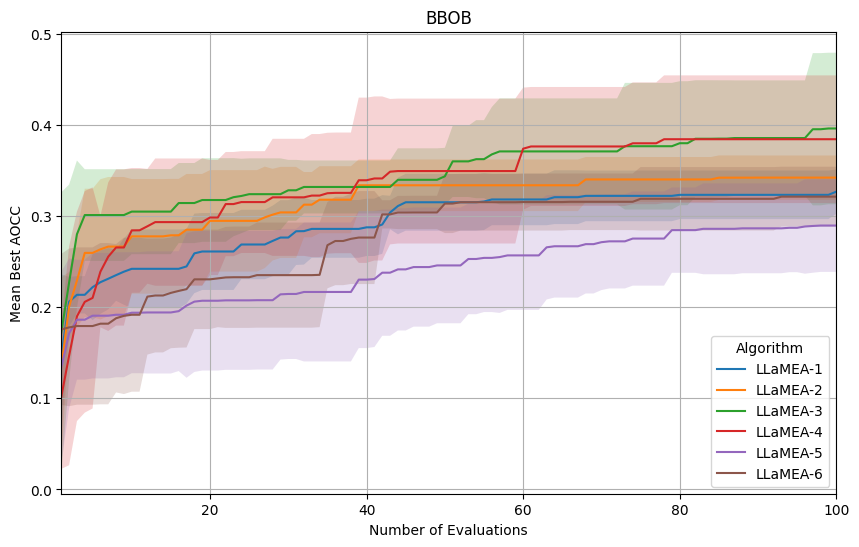

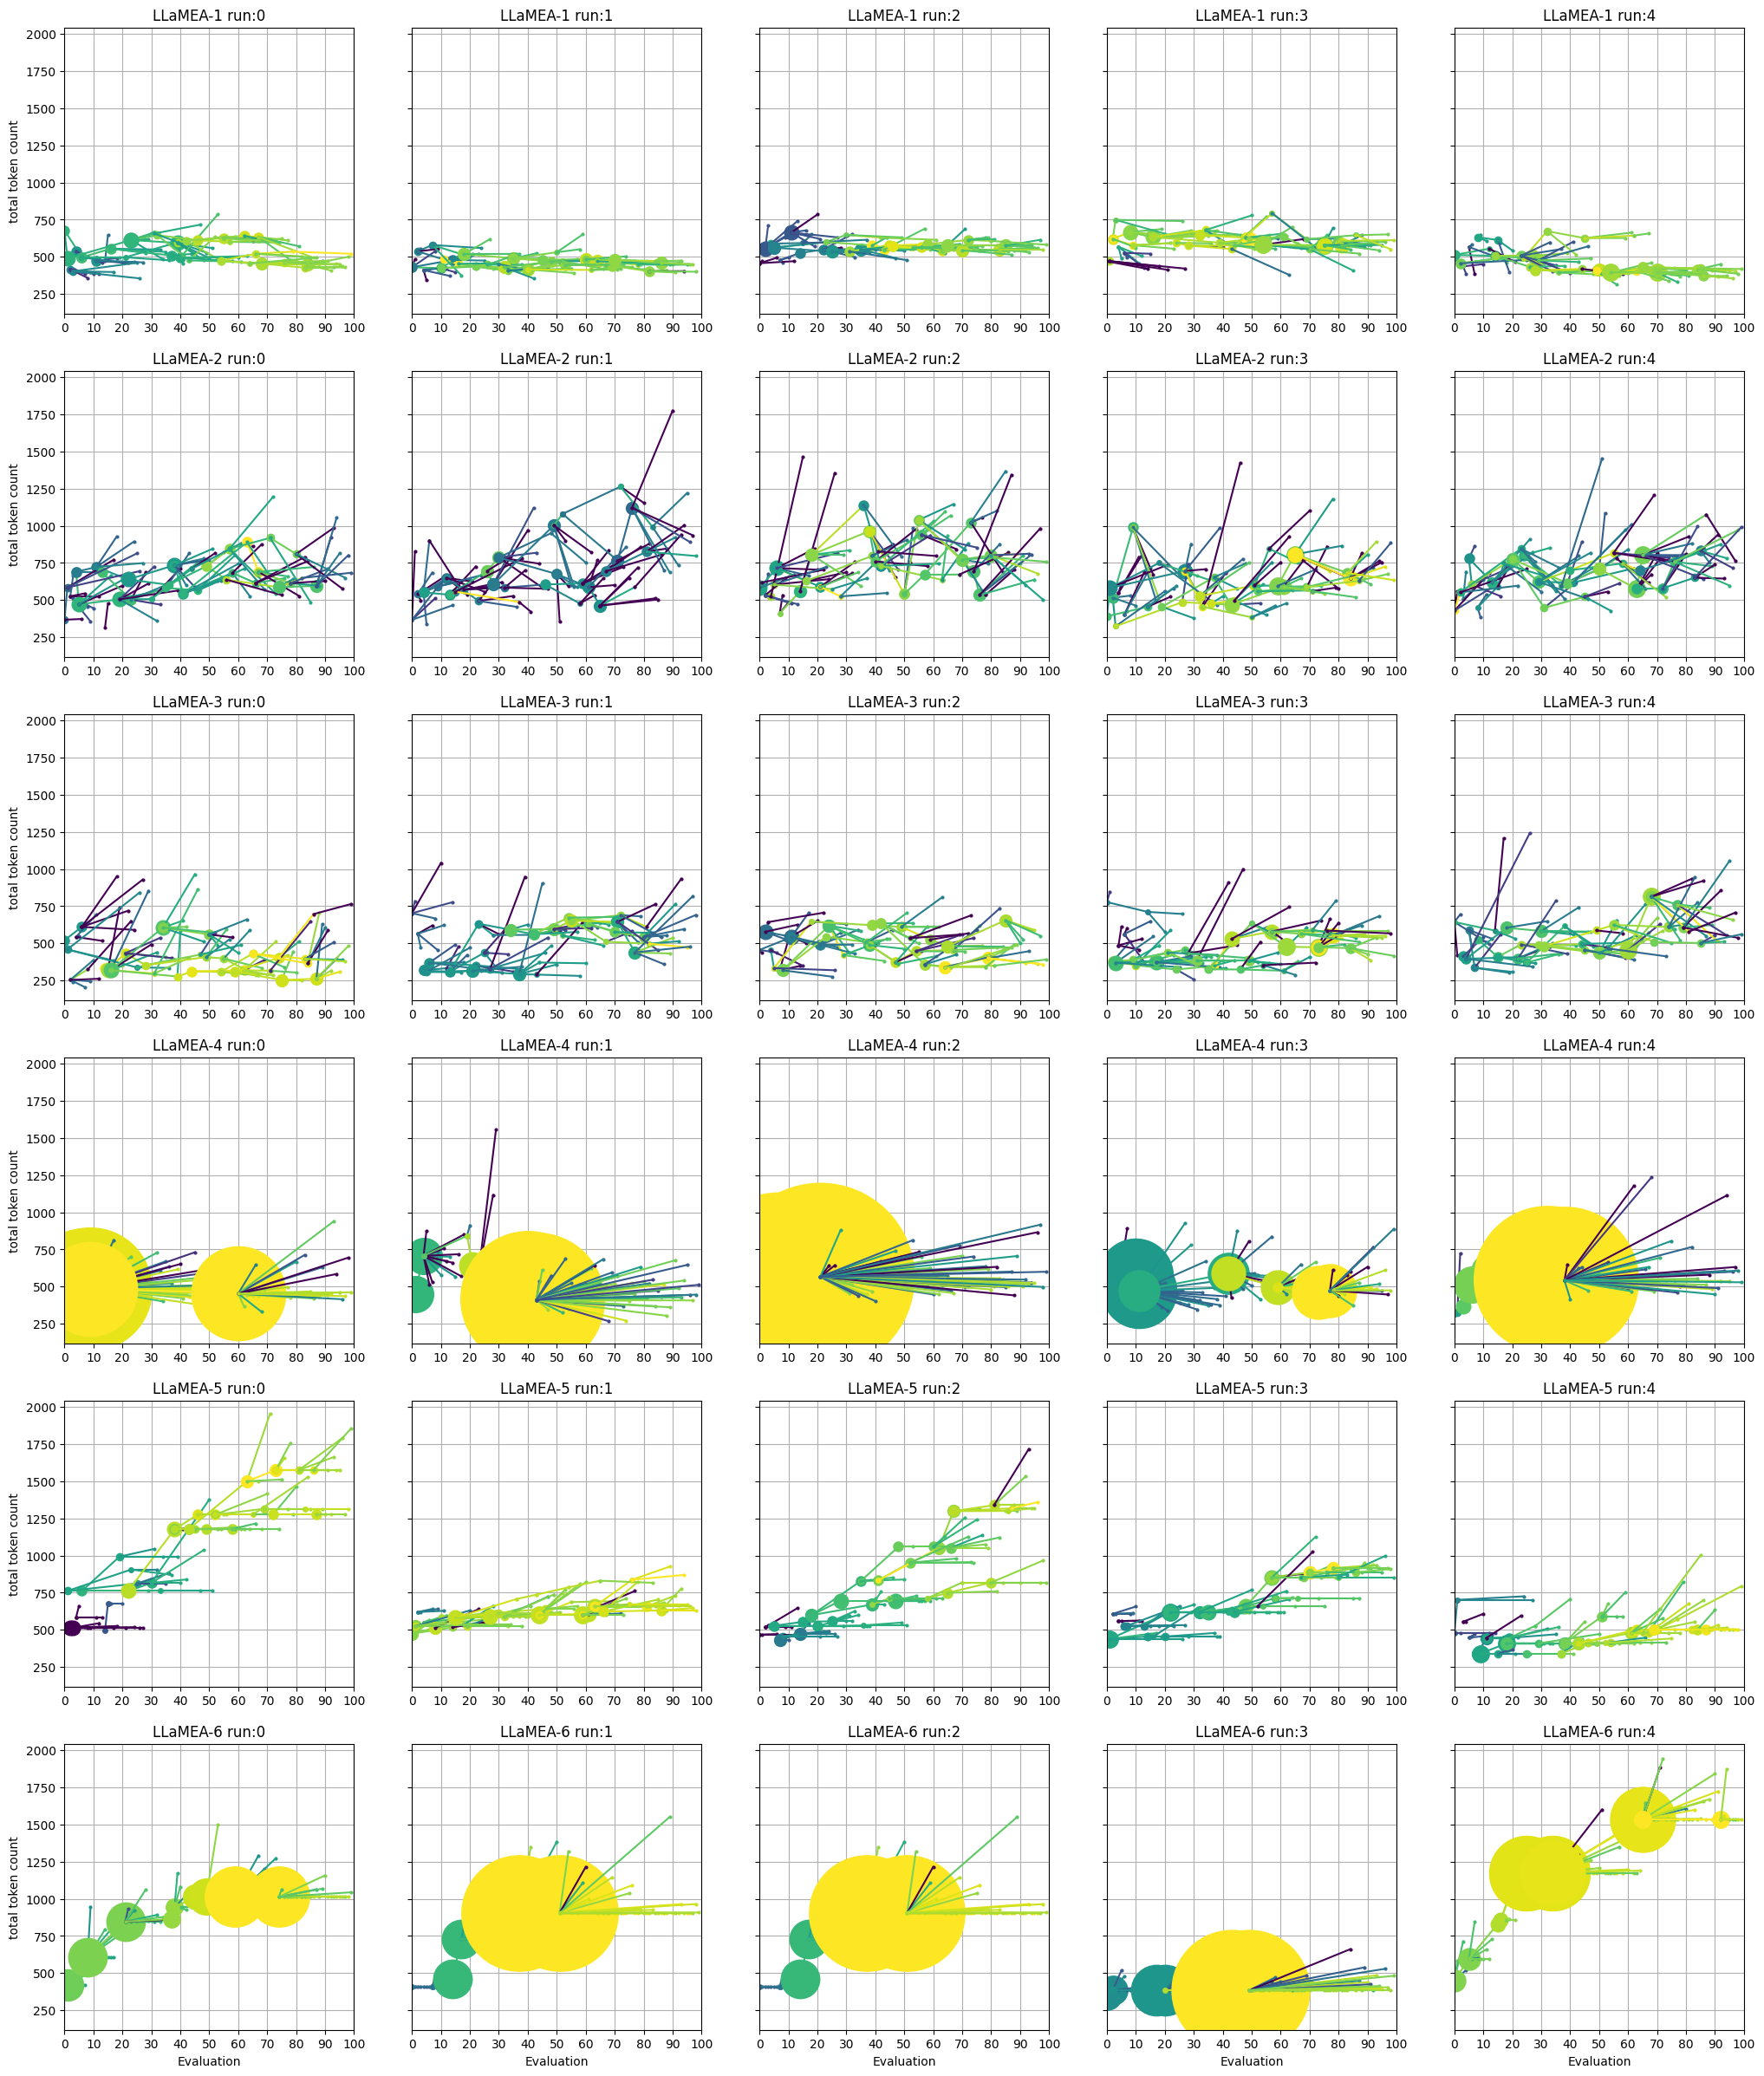

In [4]:
# Plot the converenge curves per problem and then plot the Code Evolution Graphs to inspect different runs of the otpimzers.

plot_convergence(logger, metric="AOCC", save=False, budget=100)
plot_experiment_CEG(logger, save=False, budget=100, max_seeds=10)


In [5]:
plot_convergence(logger, metric="AOCC", save=True, budget=100)
plot_experiment_CEG(logger, save=True, budget=100, max_seeds=5)

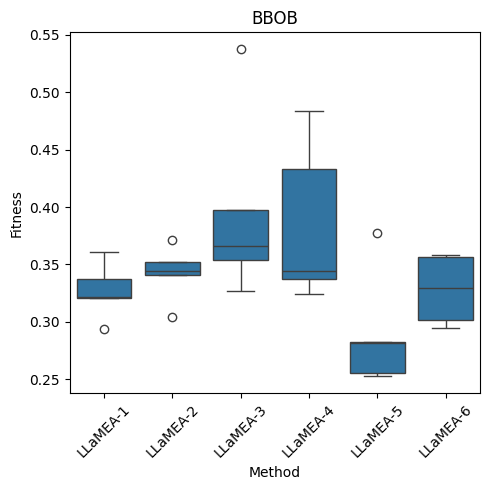

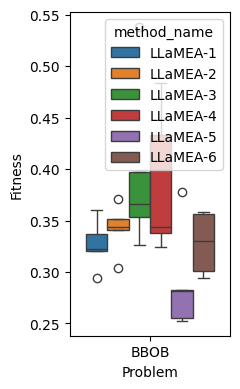

/home/neocortex/.cache/pypoetry/virtualenvs/blade-xXF9vABH-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


,BBOB
LLaMEA-1,0.33 ± 0.02 (p=0.346)
LLaMEA-2,0.34 ± 0.02 (p=0.346)
LLaMEA-3,0.40 ± 0.07 (p=0.815)
LLaMEA-4,0.38 ± 0.06 (p=0.815)
LLaMEA-5,0.29 ± 0.05 (p=0.193)
LLaMEA-6,-inf ± nan (p=nan)


In [6]:

plot_boxplot_fitness(logger)
plot_boxplot_fitness_hue(logger)

table_df = fitness_table(logger, alpha=0.05)
table_df
# Convert to LaTeX; escape=False so we can keep the \textbf{} markup
#latex_str = table_df.to_latex(escape=False)

In [10]:
#!pip install line_profiler

In [3]:
from iohblade.behaviour_metrics import compute_behavior_metrics

df_metrics = compute_behavior_metrics(df)
df_metrics


{'avg_nearest_neighbor_distance': 0.09095469504821961,
 'dispersion': 8.450942561765972,
 'avg_exploration_pct': 4.411354711501201,
 'avg_distance_to_best': 0.1958902898645619,
 'intensification_ratio': 0.9245,
 'avg_exploitation_pct': 95.5886452884988,
 'average_convergence_rate': 0.9961156062519066,
 'avg_improvement': 0.05851943413377485,
 'success_rate': 0.030203020302030203,
 'longest_no_improvement_streak': 5356,
 'last_improvement_fraction': 0.5356535653565356}

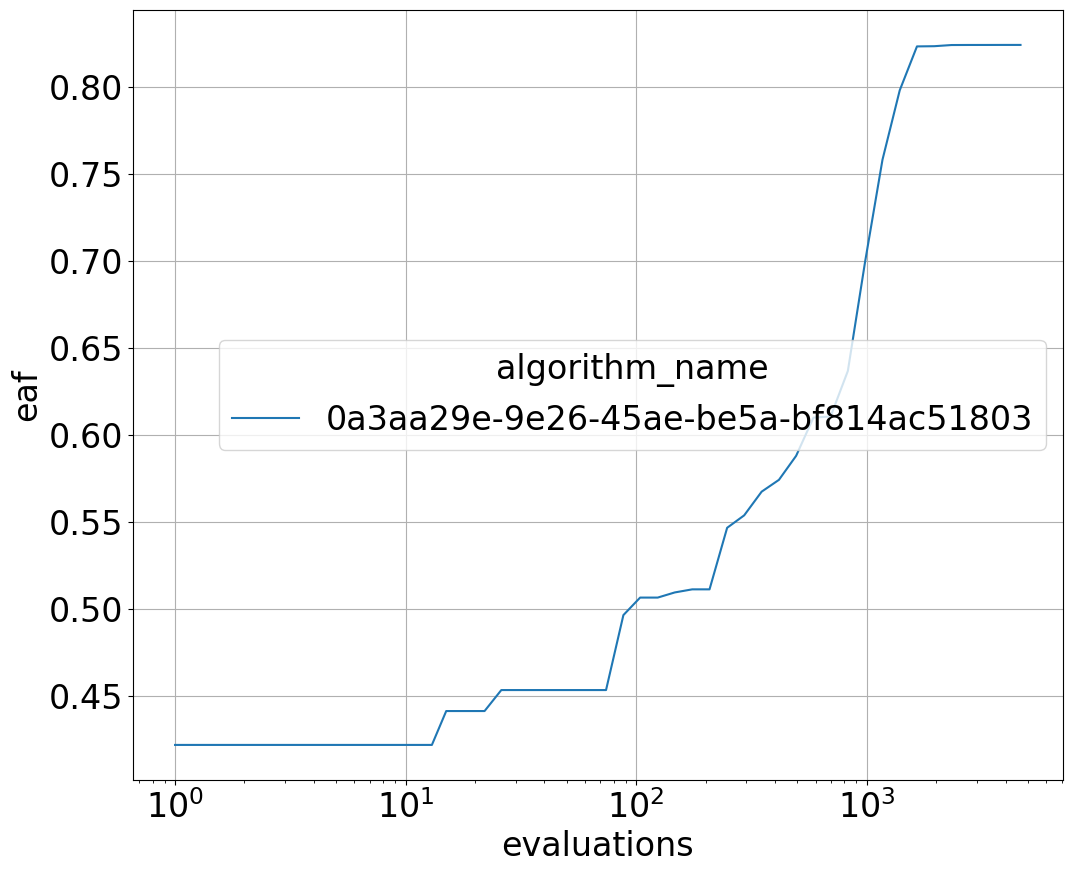

In [ ]:
import operator

df = manager.load(monotonic=True, include_meta_data=True)

fig, ax = plt.subplots(1,1, figsize=(12,10))
_ = iohinspector.plot.plot_ecdf(df.filter(pl.col("dimension") == 5), y_max=100, y_min=1e-8, ax=ax, scale_xlog=True)
plt.show()

In [ ]:
df_eaf = iohinspector.metrics.transform_fval(df, 1e-8, 1e2)
iohinspector.metrics.get_aocc(df_eaf.filter(pl.col("dimension") == 5), 10000, group_cols=['algorithm_name'])

algorithm_name,AOCC
str,f64
"""0a3aa29e-9e26-45ae-be5a-bf814a…",0.674898
